# Выполнил: Студент МАГ ИАД 2022 Бараненков Сергей

# Задание

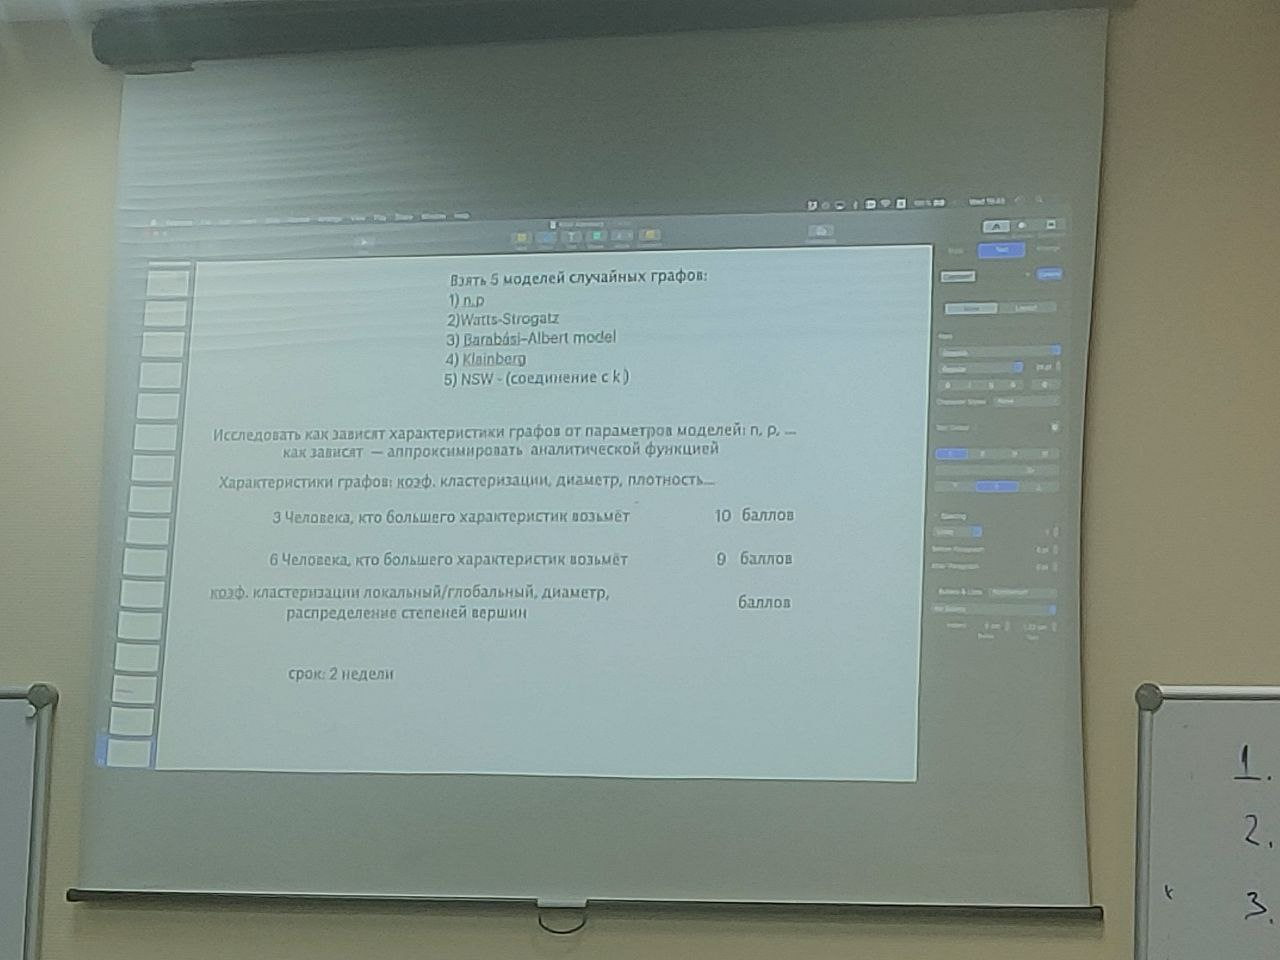

# Подключаем библиотеки

In [ ]:
from IPython.core.magic import register_line_magic
@register_line_magic
def p(args):
    for key in args.split(" "):
        print(key,": ", globals()[key])

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import distance
import heapq
import random
from typing import List, Tuple
import random
from itertools import combinations, groupby
from collections import defaultdict
from statistics import mean
from scipy.optimize import curve_fit
from scipy.stats import binom

# Определяем исследуемые метрики

In [ ]:
def get_metrics(g):
  # Является ли граф связным
  is_connected = nx.is_connected(g)

  # Диаметр - расстояние между наиболее далекими вершинами
  diameter = nx.diameter(g)
  # Плотность - отношение числа ребер к максимально возможному числу ребер
  density = nx.density(g)
  # Кф локальной кластеризации - отношение числа ребер между соседними вершинами определенной вершины к максимально возможному числу ребер между этими соседями
  local_clustering_cfs = nx.clustering(g)
  average_local_clustering_cf = nx.average_clustering(g)

  # Кф глобальной кластеризации - отношение числа треугольников, умноженному на 3 к числу триплетов
  global_clustering_cf = nx.transitivity(g)

  # Распределение степеней вершин
  degree = dict(g.degree())
  degree_values = sorted(set(degree.values()))
  degree_hist = np.array([list(degree.values()).count(x) for x in degree_values])
  degree_hist = degree_hist / np.sum(degree_hist)
  # Среднее кратчайшее расстояние между вершинами в графе
  average_length = nx.average_shortest_path_length(g)

  return is_connected, diameter, density, average_local_clustering_cf, global_clustering_cf, (degree_values, degree_hist), average_length


# Иногда генерируется несколко компонент связности - создадим функцию, которая если граф не является связным связывает его компоненты в одну случайным образом

In [ ]:
def make_graph_connected(graph, verbose = False):
    # Получаем список связных компонентов графа
    components = dict(enumerate(nx.connected_components(graph)))

    # Если граф уже связный, возвращаем его без изменений
    if len(components) == 1:
        return graph

    if verbose:
      print('Некоторые компоненты были принудительно случайно связаны')

    components_combs = combinations(components.keys(), r=2)

    for _, node_edges in groupby(components_combs, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_comps = random.choice(node_edges)
        source = random.choice(list(components[random_comps[0]]))
        target = random.choice(list(components[random_comps[1]]))
        graph.add_edge(source, target)

    return graph

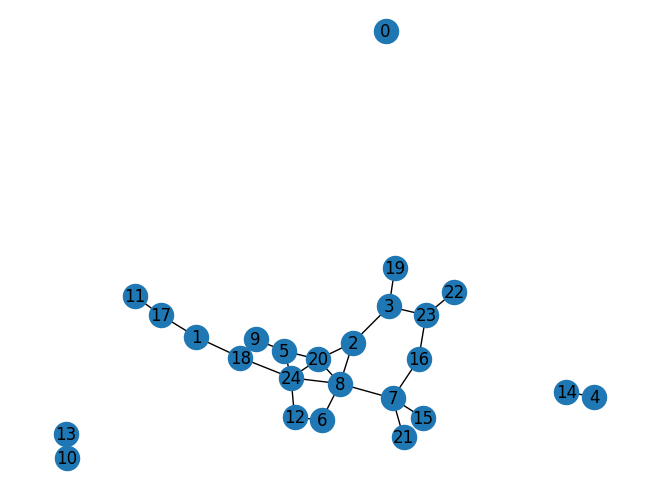

In [ ]:
g = nx.erdos_renyi_graph(25, 0.1, seed=228)
nx.draw(g, with_labels=True)

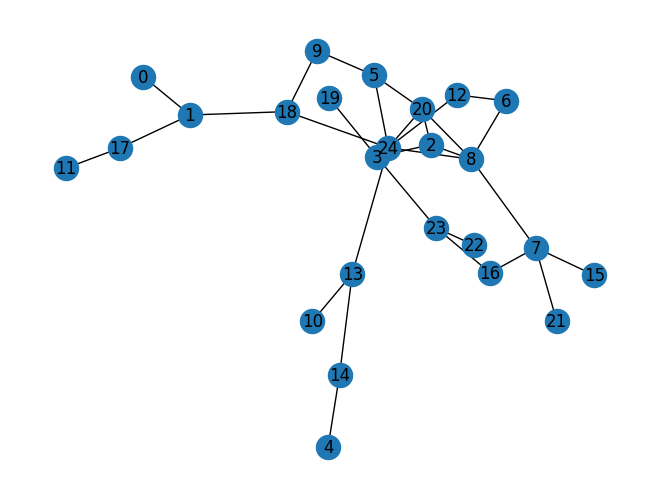

In [ ]:
g = make_graph_connected(g)
nx.draw(g, with_labels=True)

# Определим базовые аппроксимирующие функции

In [ ]:
def fit_linear(x, y):
  args = np.polyfit(x, y, 1)
  fn = np.poly1d(args)
  return f'<linear> {args[0]:.2f} * x + {args[1]:.2f}', fn(x)

def fit_poly2d(x, y):
  args = np.polyfit(x, y, 2)
  fn = np.poly1d(args)
  return f'<poly> {args[0]:.2f} * x^2 + {args[1]:.2f} * x + {args[2]:.2f}', fn(x)

def fit_log(x, y):
  def func(x, a, b):
    return a * np.log(x) + b

  args, _ = curve_fit(func, x, y, maxfev=10000)

  values = func(x, *args)

  return f'<log> {args[0]:.2f} * ln x + {args[1]:.2f}', values

def fit_exponential(x, y):
  args = np.polyfit(np.exp(x), y, 2)
  fn = np.poly1d(args)

  return f'<exponential> {args[0]:.2f} * e^x + {args[1]:.2f}', fn(x)

def fit_power_law(x, y):
  def func(x, a, m):
    return a * x**m

  args, _ = curve_fit(func, x, y, maxfev=10000)

  values = func(x, *args)

  return f'<power_law> {args[0]:.2f} * x^{args[1]:.2f}', values

# И еще ряд вспомогательных функций

In [ ]:
metric_names = ['diameter', 'density', 'average_local_clustering_cf', 'global_clustering_cf', 'average_length']

def calc_metrics(parameter, get_graph, save_to, avg_times = 3):
  local_dict = defaultdict(list)
  for _ in range(avg_times):
    g = get_graph(parameter)
    is_connected, diameter, density, average_local_clustering_cf, global_clustering_cf, (degree_values, degree_hist), average_length = get_metrics(g)

    for key in metric_names:
      local_dict[key].append(locals()[key])

  # гистограмма
  save_to['degree'].append((degree_values, degree_hist))

  for key in local_dict:
    save_to[key].append(mean(local_dict[key]))


def plot_metrics(x, metrics, param_name, approxim_by):
  fig, axs = plt.subplots(1, len(metric_names), figsize=(25, 5))

  for i, name in enumerate(metric_names):
      values = metrics[name]
      axs[i].plot(x, values, label = 'func')

      axs[i].set_title(f'{name}', fontsize=8)
      axs[i].set_xlabel(param_name)
      axs[i].set_ylabel('value')

      if name in approxim_by:
        for fn in approxim_by[name]:
          approxim_params, approxim_values = fn(x, values)
          axs[i].plot(x, approxim_values, label = approxim_params)

      axs[i].legend()

  plt.tight_layout()
  plt.show()

  # Распределение степеней
  fig, axs = plt.subplots(1, len(x), figsize=(25, 5))

  for i, n in enumerate(x):
      degree_key, degree_count = metrics['degree'][i]
      axs[i].plot(degree_key, degree_count, label = 'func')
      axs[i].set_title(f'degree {param_name}={n}', fontsize=8)
      axs[i].set_xlabel('degree')
      axs[i].set_ylabel('probability')

      if 'degree' in approxim_by:
        for fn in approxim_by['degree']:
          approxim_params, approxim_values = fn(degree_key, degree_count)
          axs[i].plot(degree_key, approxim_values, label = approxim_params)

      axs[i].legend()

  plt.tight_layout()
  plt.show()

# Для каждого типа графов cделаем:
1. Предварительный визуальный анализ - проверим что графы строятся правильно.
2. Визуализируем зависимость метрик от какого-либо гиперпараметра при остальных фиксированных гиперпараметров.

# Erdos-Renyi

n - количество вершин, p - вероятность появления ребра

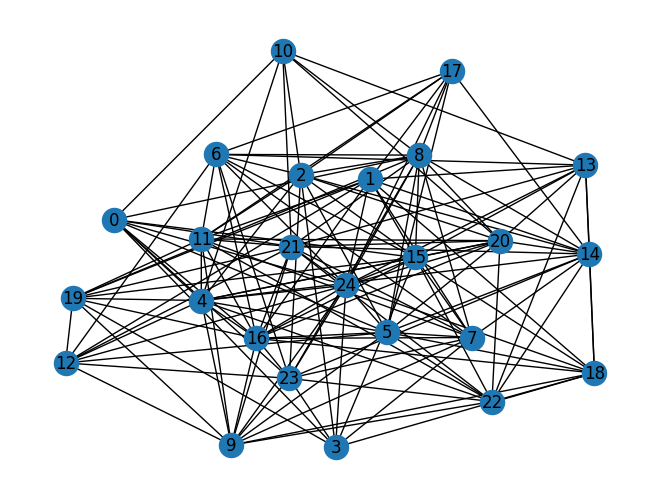

In [ ]:
g = make_graph_connected(nx.erdos_renyi_graph(25, 0.5, seed=228))
nx.draw(g, with_labels = True)

is_connected :  True
diameter :  2
density :  0.49
average_local_clustering_cf :  0.48414630467571645
global_clustering_cf :  0.47702539298669894
average_length :  1.51


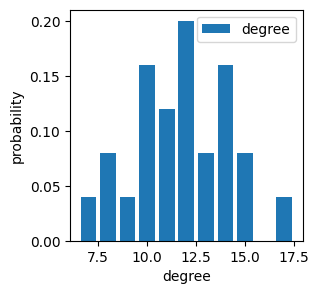

In [ ]:
is_connected, diameter, density, average_local_clustering_cf, global_clustering_cf, (degree_values, degree_hist), average_length = get_metrics(g)
%p is_connected
%p diameter
%p density
%p average_local_clustering_cf
%p global_clustering_cf
%p average_length

plt.figure(figsize=(3, 3))
plt.bar(degree_values, degree_hist)
plt.legend(['degree'])
plt.xlabel('degree')
plt.ylabel('probability')
plt.show()

In [ ]:
n_range = [x * x for x in range(4, 20, 2)]
p_range = [0.2, 0.35, 0.5, 0.65, 0.8]
n_metrics = defaultdict(list)
fixed_p = 0.5
p_metrics = defaultdict(list)
fixed_n = 256


# Метрики по n при фиксированном p
for param in n_range:
    get_graph = lambda param: make_graph_connected(nx.erdos_renyi_graph(param, fixed_p, seed=228))
    calc_metrics(param, get_graph, n_metrics)

# Метрики по p при фиксированном n
for param in p_range:
    get_graph = lambda param: make_graph_connected(nx.erdos_renyi_graph(fixed_n, param, seed=228))
    calc_metrics(param, get_graph, p_metrics)

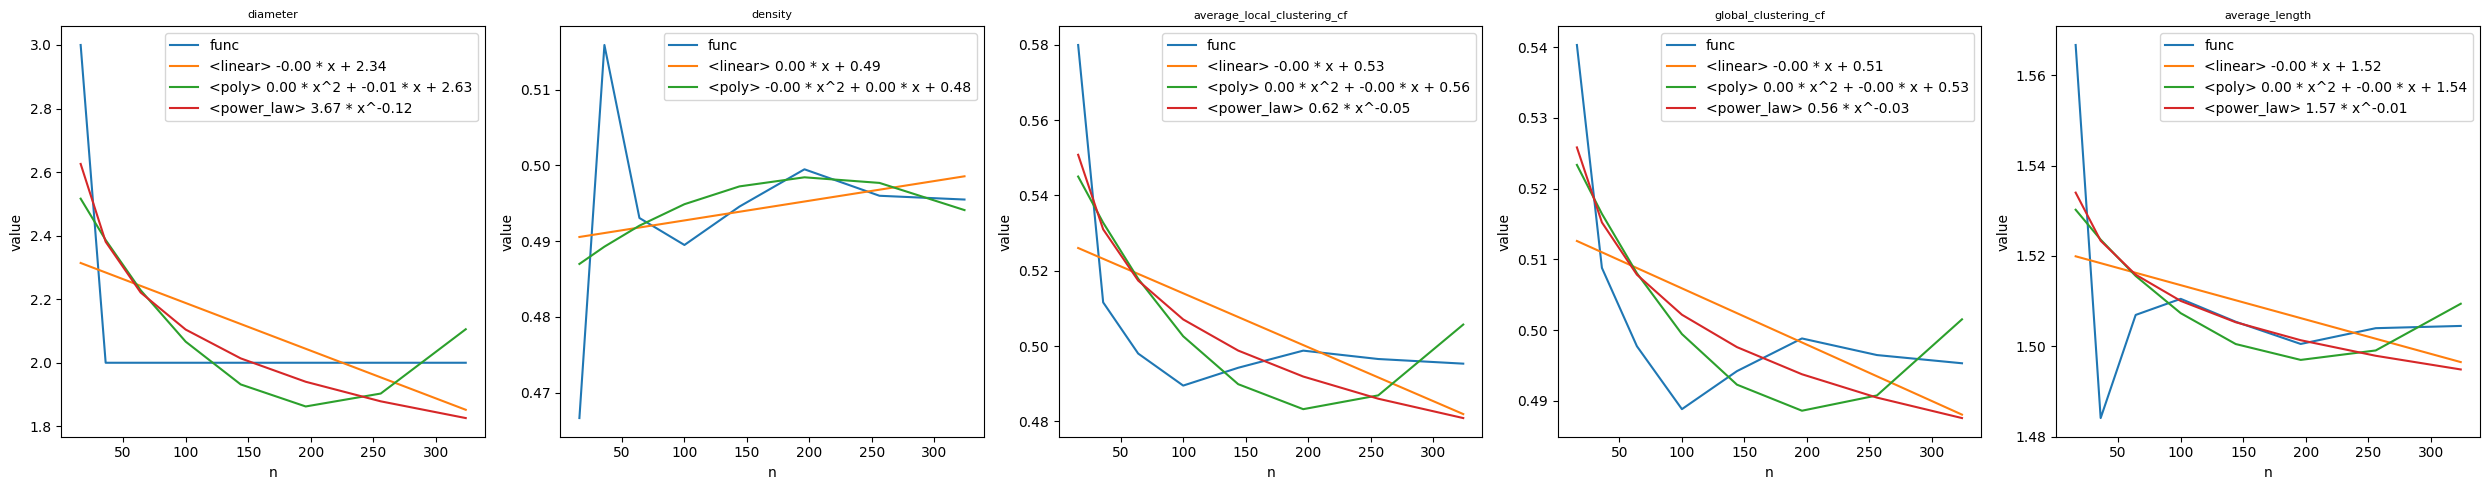

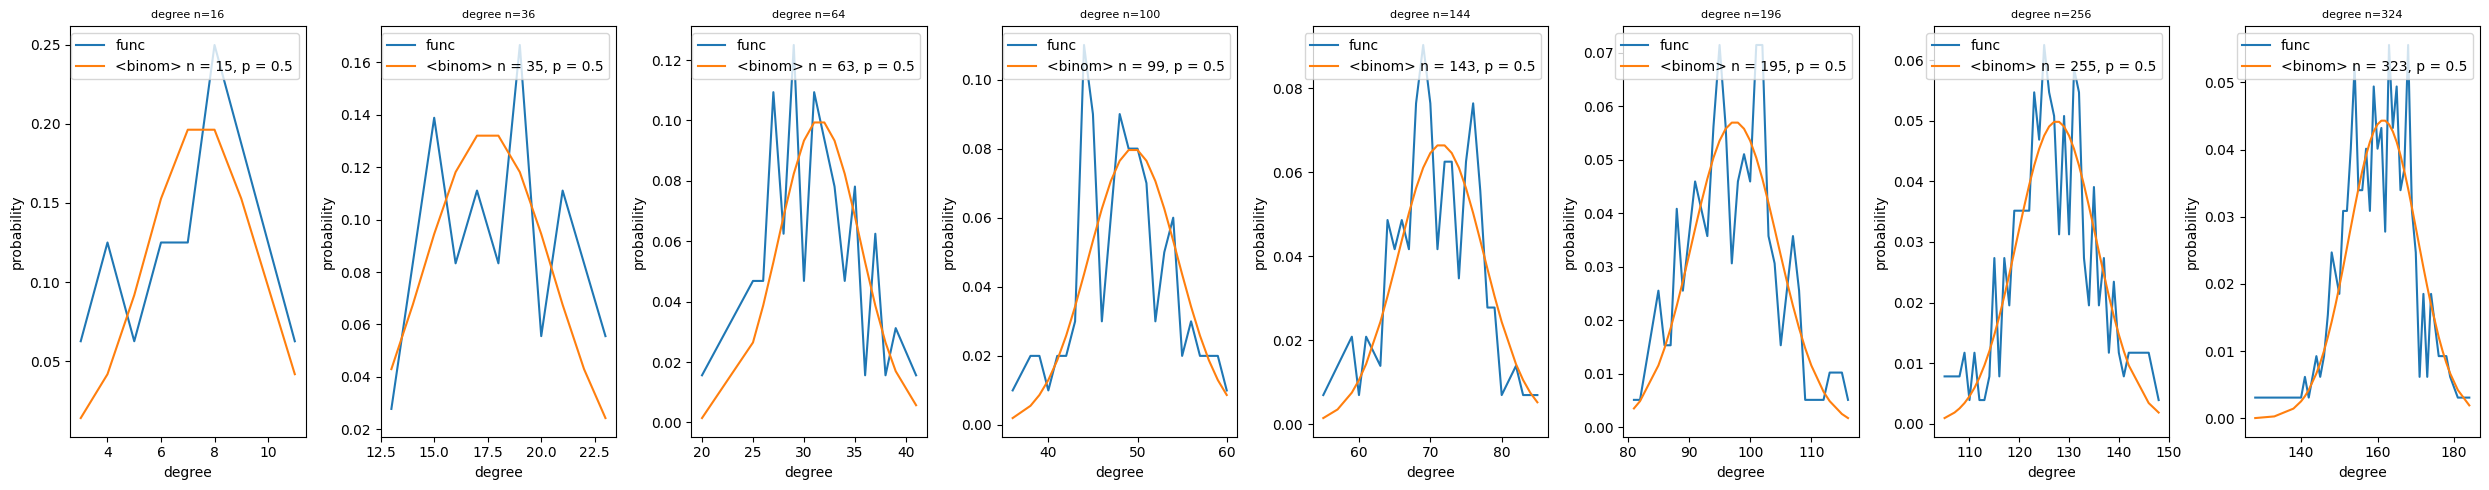

In [ ]:
def my_binom():
  i = 0
  def func(x, y):
    nonlocal i
    n = n_range[i] - 1
    p = fixed_p

    values = binom.pmf(x, n, p)
    res = f'<binom> n = {n}, p = {p}', values
    i += 1
    return res

  return func

approxim_by = {
    'diameter': [fit_linear, fit_poly2d, fit_power_law],
    'density': [fit_linear, fit_poly2d],
    'average_local_clustering_cf': [fit_linear, fit_poly2d, fit_power_law],
    'global_clustering_cf': [fit_linear, fit_poly2d, fit_power_law],
    'average_length': [fit_linear, fit_poly2d, fit_power_law],
    'degree': [my_binom()],
}

plot_metrics(n_range, n_metrics, 'n', approxim_by)

Анализ:

Все верхние метрики при увеличении n стремятся к константному значению

1. diameter стремится к 2
2. density стремится к fixed_p
3. коэффициенты кластеризации также стремятся к fixed_p
4. средняя длина стремится к 1.5

Эти графики сложно аппроксимировать нормально автоматически, но очевидно что это должна быть линейная функция и при больших n аппроксимирующая прямая будет стремиться к горизонтальной линии

Нижние графики можно хорошо аппроксимировать биномиальным распределением с N = n - 1, P = fixed_p.

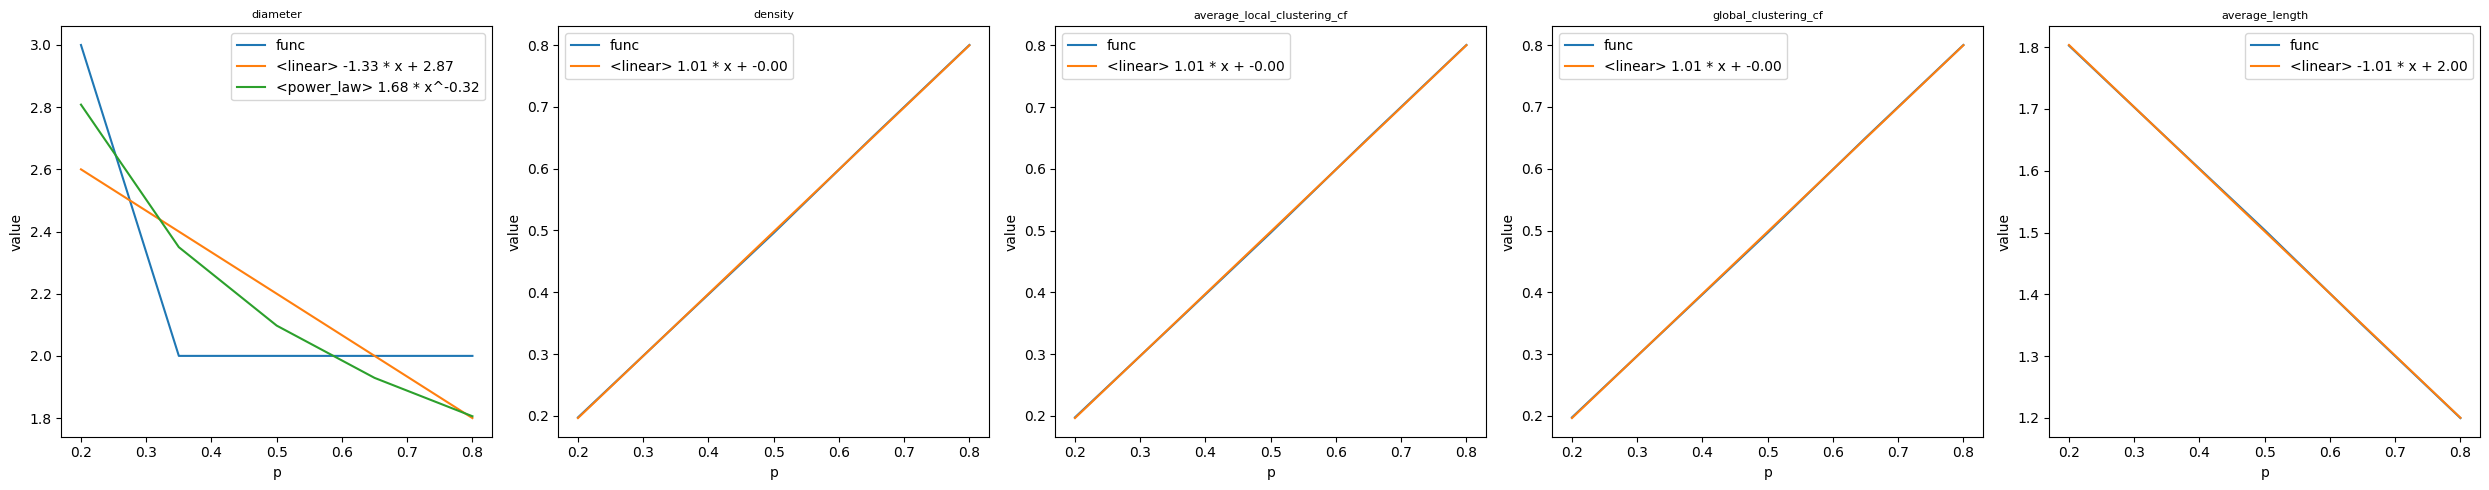

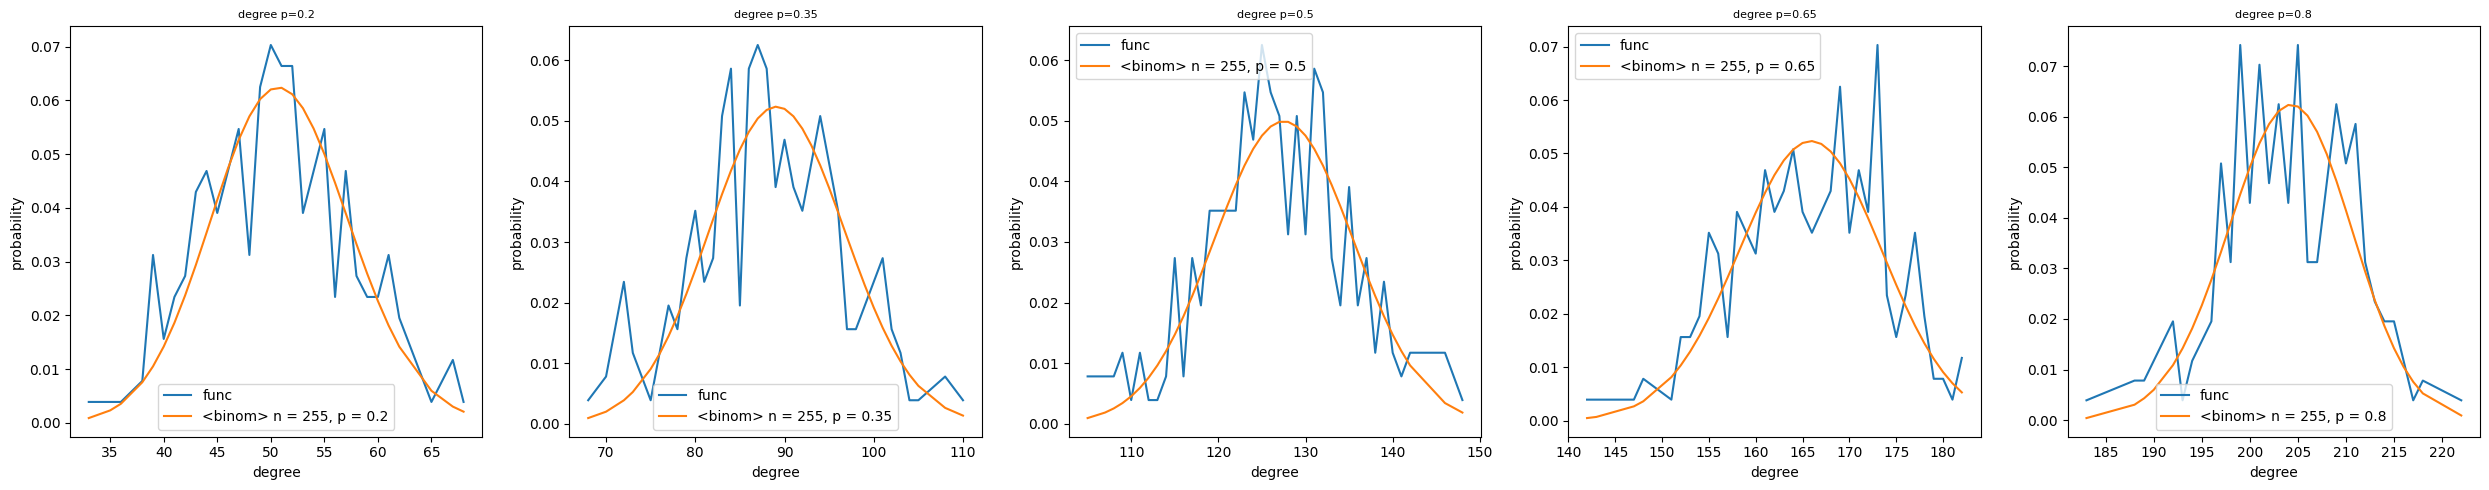

In [ ]:
def my_binom():
  i = 0
  def func(x, y):
    nonlocal i
    n = fixed_n - 1
    p = p_range[i]

    values = binom.pmf(x, n, p)
    res = f'<binom> n = {n}, p = {p}', values
    i += 1
    return res

  return func

approxim_by = {
    'diameter': [fit_linear, fit_power_law],
    'density': [fit_linear],
    'average_local_clustering_cf': [fit_linear],
    'global_clustering_cf': [fit_linear],
    'average_length': [fit_linear],
    'degree': [my_binom()],
}

plot_metrics(p_range, p_metrics, 'p', approxim_by)

Анализ:

1. diameter при малом p сначала равен 3 и при увеличении p стремится к 2
2. density зависит от p как f(x) = x
3. коэффициенты кластеризации также зависят от p как f(x) = x
4. средняя длина линейно уменьшается при увеличении p

Нижние графики можно хорошо аппроксимировать биномиальным распределением с N = n - 1, P = fixed_p.

Выводы: Полученные результаты схожи с теоретическими - графы имеют малый диаметер и биномиальное распределение.

# Watts–Strogatz

n - количество вершин, p - вероятность перепривязать ребро, k - количество соседних вершин, с которыми будет соединена данная вершина изначально

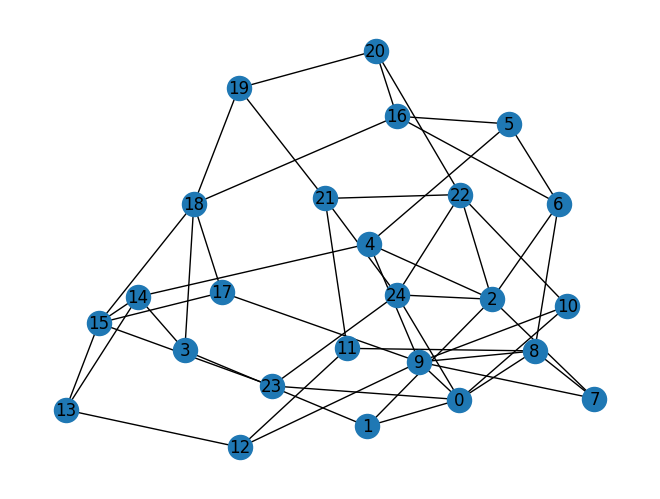

In [ ]:
g = nx.connected_watts_strogatz_graph(25, 5, 0.5, seed=228)
nx.draw(g, with_labels = True)

is_connected :  True
diameter :  4
density :  0.16666666666666666
average_local_clustering_cf :  0.16304761904761902
global_clustering_cf :  0.16167664670658682
average_length :  2.31


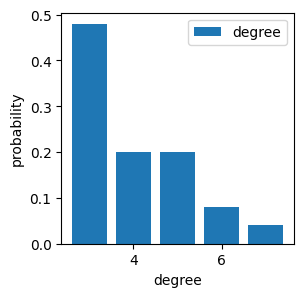

In [ ]:
is_connected, diameter, density, average_local_clustering_cf, global_clustering_cf, (degree_values, degree_hist), average_length = get_metrics(g)
%p is_connected
%p diameter
%p density
%p average_local_clustering_cf
%p global_clustering_cf
%p average_length

plt.figure(figsize=(3, 3))
plt.bar(degree_values, degree_hist)
plt.legend(['degree'])
plt.xlabel('degree')
plt.ylabel('probability')
plt.show()

In [ ]:
n_range = [x * x for x in range(4, 40, 4)]
p_range = [0.2, 0.35, 0.5, 0.65, 0.8]
k_range = [2, 3, 4, 5]
n_metrics = defaultdict(list)
fixed_p = 0.5
p_metrics = defaultdict(list)
fixed_n = 256
k_metrics =  defaultdict(list)
fixed_k = 3

# Метрики по n
for param in n_range:
    get_graph = lambda param: nx.connected_watts_strogatz_graph(param, fixed_k, fixed_p, seed=228)
    calc_metrics(param, get_graph, n_metrics, avg_times=10)

# Метрики по p
for param in p_range:
    get_graph = lambda param: nx.connected_watts_strogatz_graph(fixed_n, fixed_k, param, seed=228)
    calc_metrics(param, get_graph, p_metrics, avg_times=10)

# Метрики по k
for param in k_range:
    get_graph = lambda param: nx.connected_watts_strogatz_graph(fixed_n, param, fixed_p, seed=228)
    calc_metrics(param, get_graph, k_metrics, avg_times=10)

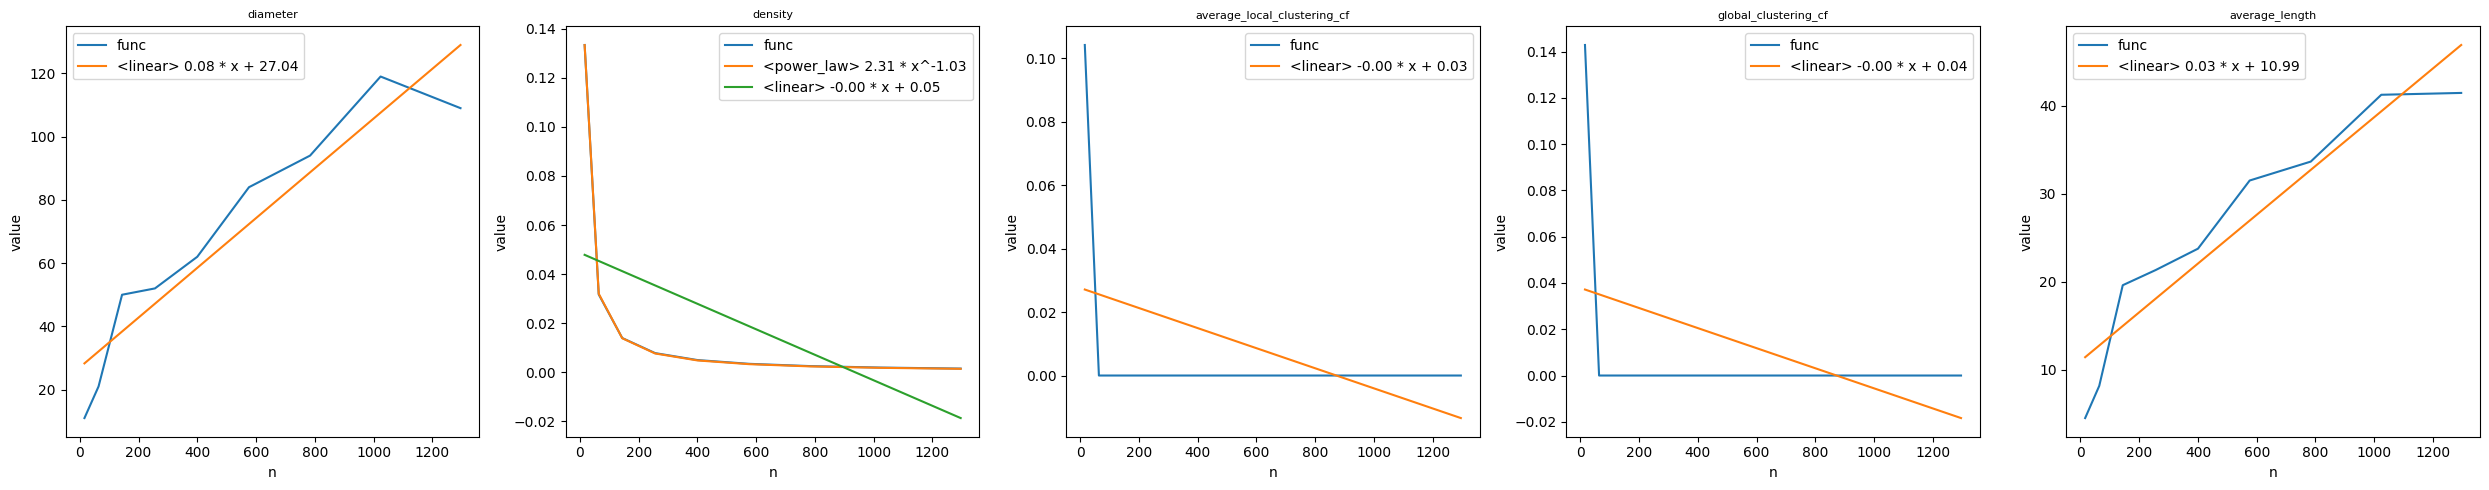

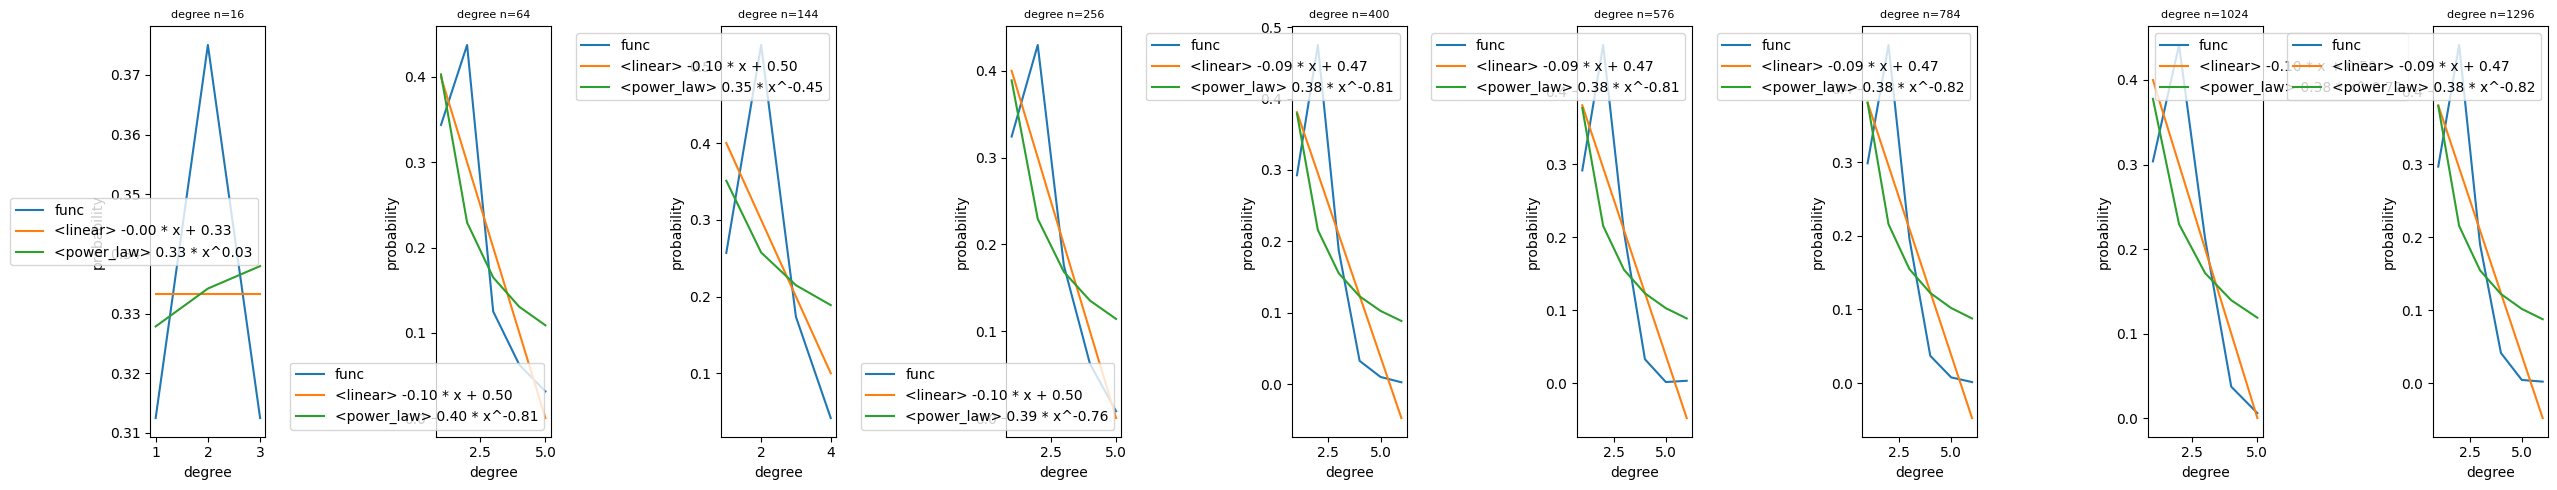

In [ ]:
approxim_by = {
    'diameter': [fit_linear],
    'density': [fit_power_law, fit_linear],
    'average_local_clustering_cf': [fit_linear],
    'global_clustering_cf': [fit_linear],
    'average_length': [fit_linear],
    'degree': [fit_linear, fit_power_law],
}

plot_metrics(n_range, n_metrics, 'n', approxim_by)

Анализ:

1. diameter и средняя пути линейно увеличиваются при увеличении n
2. density растет обратно пропорционально n. Ее можно аппроксимировать как c * 1/x
3. коэффициенты кластеризации кажется что не зависят от n и замирают на определенном значении

Нижние графики можно с невысоким успехом аппроксимировать линейной функцией. В теории для данной модели это должен быть график Dirac delta function. Можно заметить, что распределение степеней вершин не меняется относительно n.

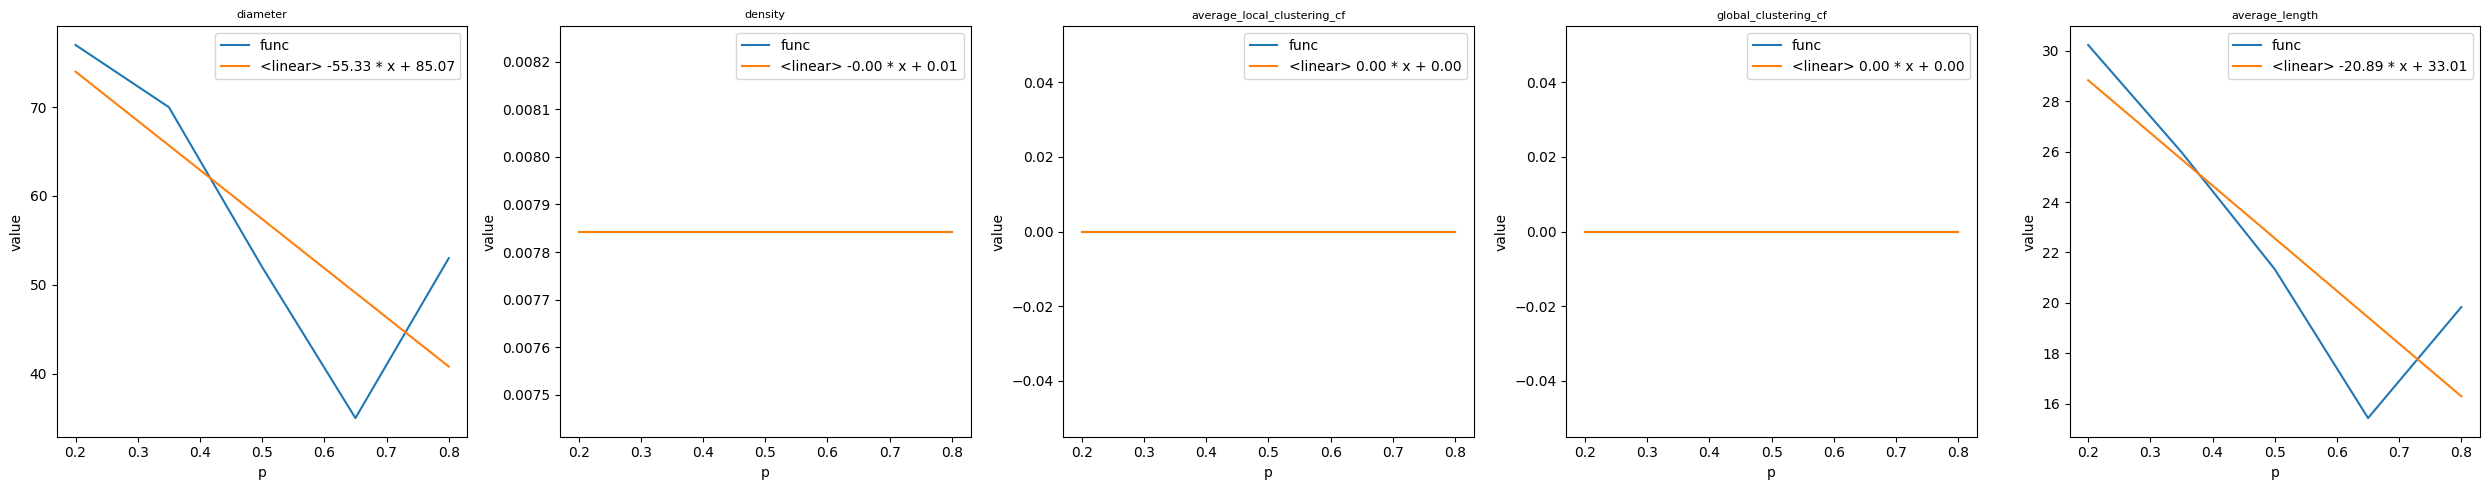

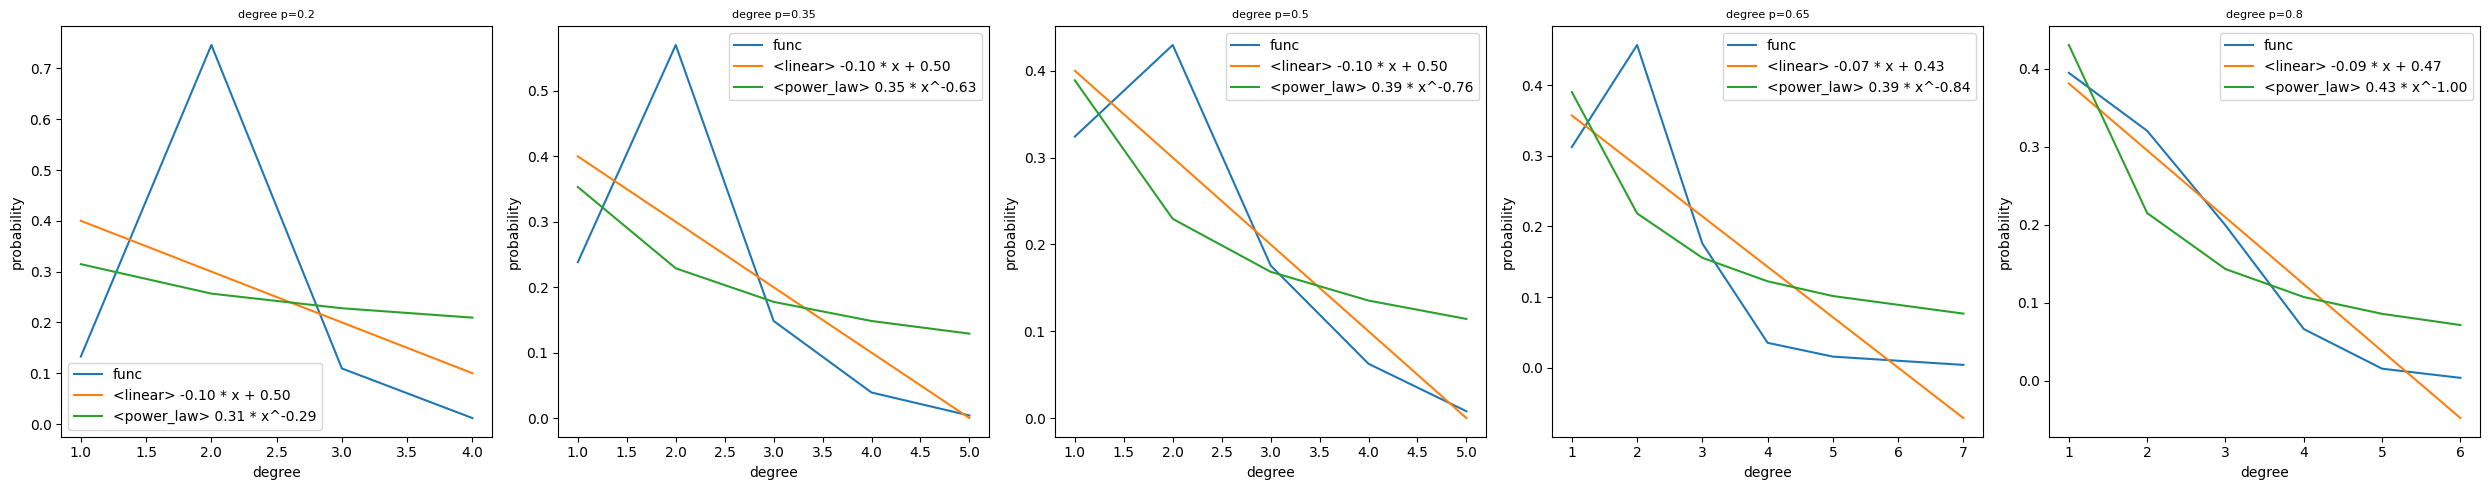

In [ ]:
approxim_by = {
    'diameter': [fit_linear],
    'density': [fit_linear],
    'average_local_clustering_cf': [fit_linear],
    'global_clustering_cf': [fit_linear],
    'average_length': [fit_linear],
    'degree': [fit_linear, fit_power_law],
}

plot_metrics(p_range, p_metrics, 'p', approxim_by)

Анализ:

1. diameter и средняя пути линейно уменьшаются при увеличении n
2. density не меняется в зависимости от p
3. коэффициенты кластеризации не меняются в зависимости от p

Нижние графики можно с невысоким успехом аппроксимировать линейной функцией. На нижних графиках зависимость распределения степеней вершин от p не выявлена

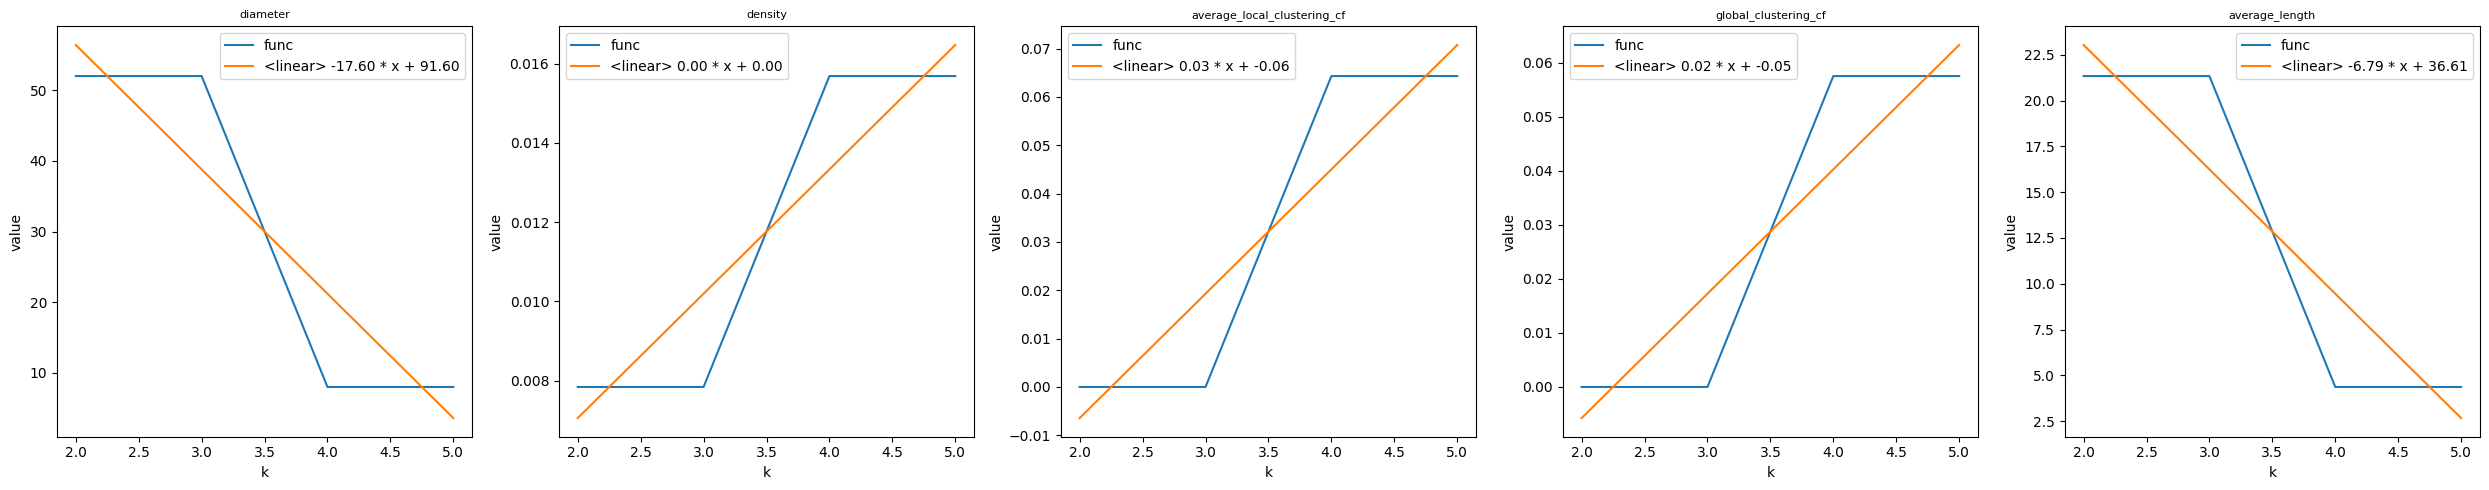

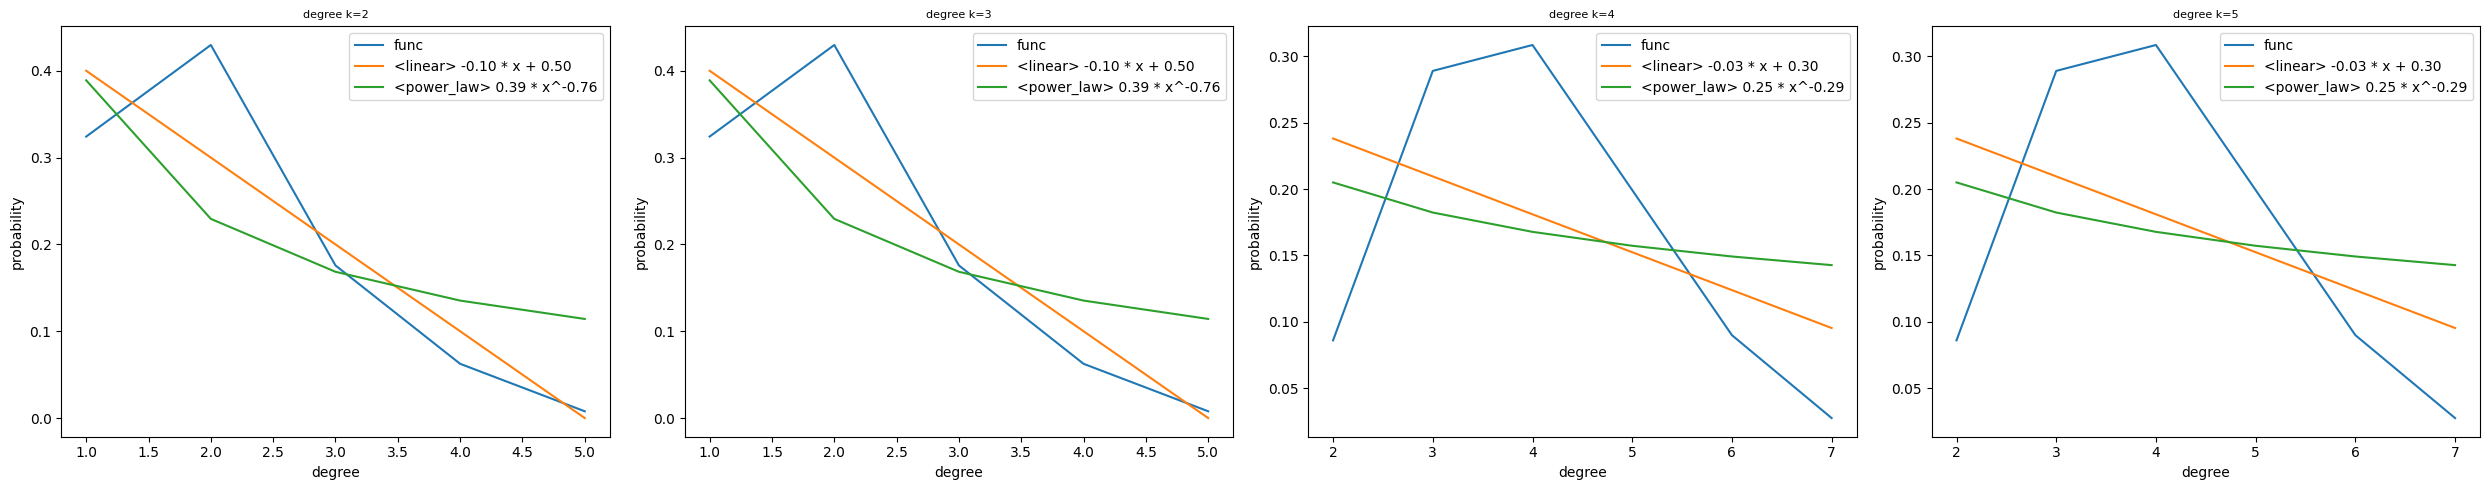

In [ ]:
approxim_by = {
    'diameter': [fit_linear],
    'density': [fit_linear],
    'average_local_clustering_cf': [fit_linear],
    'global_clustering_cf': [fit_linear],
    'average_length': [fit_linear],
    'degree': [fit_linear, fit_power_law],
}

plot_metrics(k_range, k_metrics, 'k', approxim_by)

Анализ:

1. diameter и средняя пути линейно уменьшаются при увеличении k
2. density увеличивается при увеличении k
3. коэффициенты кластеризации линейно уменьшаются при увеличении k

Нижние графики можно с невысоким успехом аппроксимировать линейной функцией. На нижних графиках можно предположить смещение пика вправо при увеличении k, но это может быть погрешность измерений

Выводы: Модель производит графы, имеющие большой диаметр, линейно растущий при увеличении n. Коэфициент кластеризации растет при увеличении k, явных зависимостей распределения степеней вершин относительно гиперпараметров не выявлено.

# Barabasi-Albert

n - количество вершин, m - со сколькими вершинами соединить каждую новую вершину

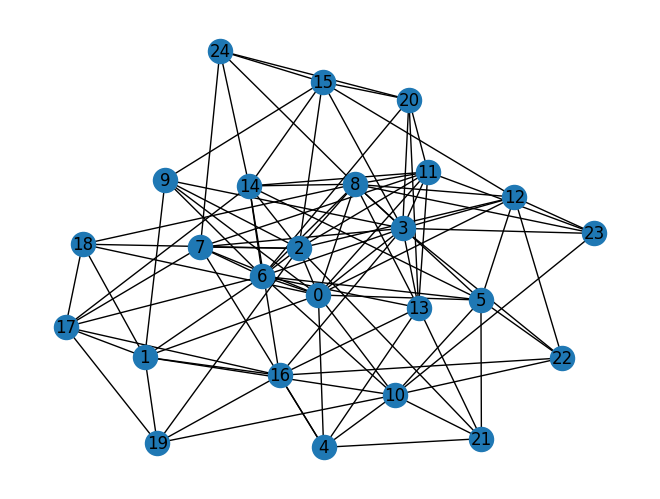

In [ ]:
g = make_graph_connected(nx.barabasi_albert_graph(25, 5, seed=228))
nx.draw(g, with_labels = True)

is_connected :  True
diameter :  3
density :  0.3333333333333333
average_local_clustering_cf :  0.3901429681429683
global_clustering_cf :  0.376425855513308
average_length :  1.71


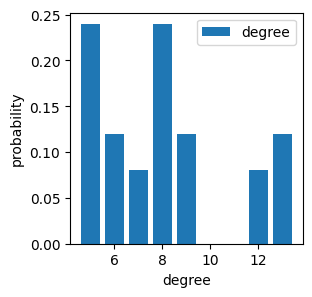

In [ ]:
is_connected, diameter, density, average_local_clustering_cf, global_clustering_cf, (degree_values, degree_hist), average_length = get_metrics(g)
%p is_connected
%p diameter
%p density
%p average_local_clustering_cf
%p global_clustering_cf
%p average_length

plt.figure(figsize=(3, 3))
plt.bar(degree_values, degree_hist)
plt.legend(['degree'])
plt.xlabel('degree')
plt.ylabel('probability')
plt.show()

In [ ]:
m_range = [1, 2, 3, 4, 5]
n_range = [x * x for x in range(4, 20, 2)]

n_metrics = defaultdict(list)
fixed_m = 3

m_metrics = defaultdict(list)
fixed_n = 256

# Метрики по n
for param in n_range:
    get_graph = lambda param: make_graph_connected(nx.barabasi_albert_graph(param, fixed_m, seed=228))
    calc_metrics(param, get_graph, n_metrics, avg_times=10)

# Метрики по m
for param in m_range:
    get_graph = lambda param: make_graph_connected(nx.barabasi_albert_graph(fixed_n, param, seed=228))
    calc_metrics(param, get_graph, m_metrics, avg_times=10)

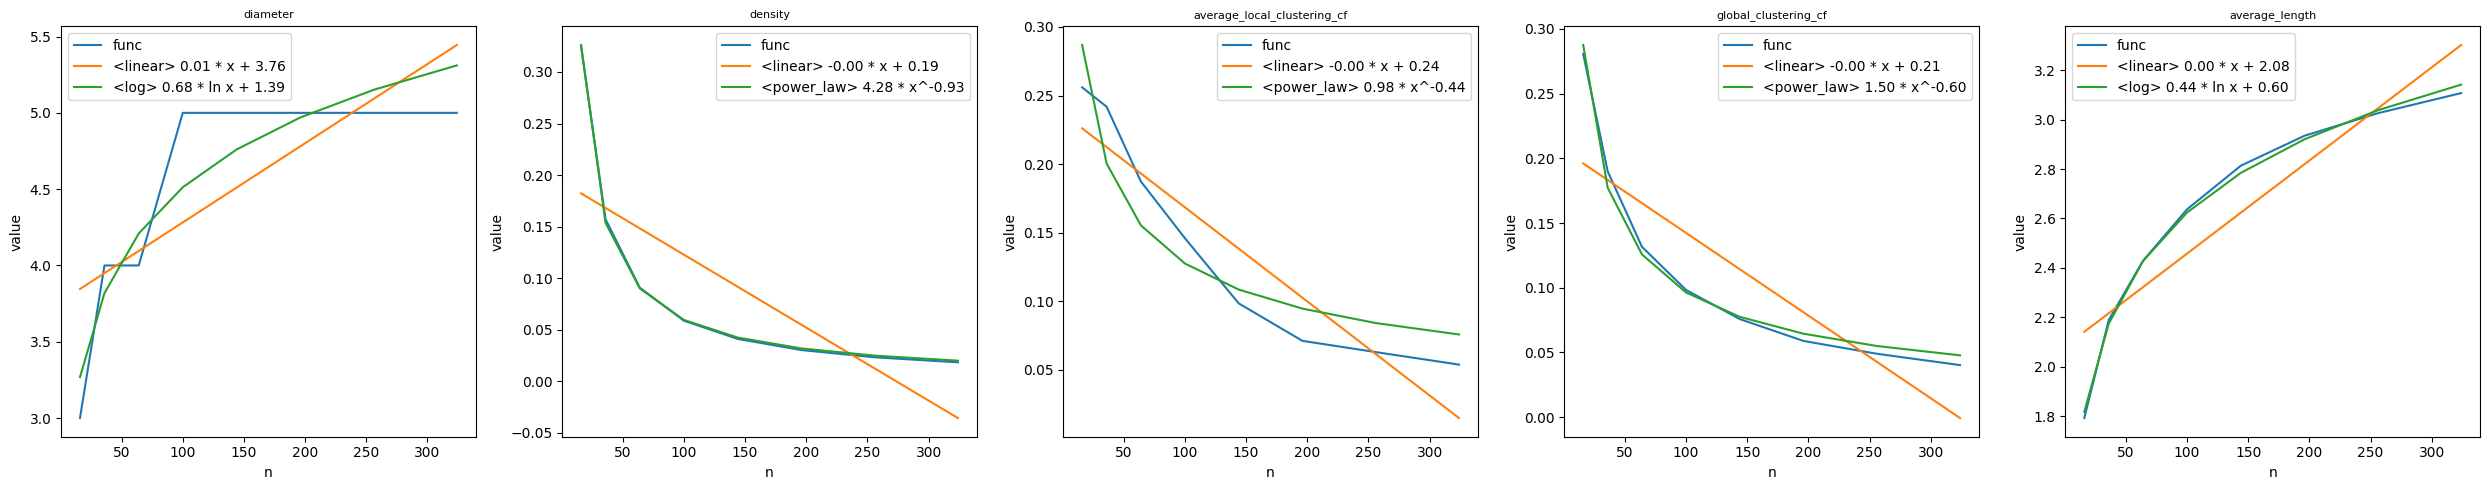

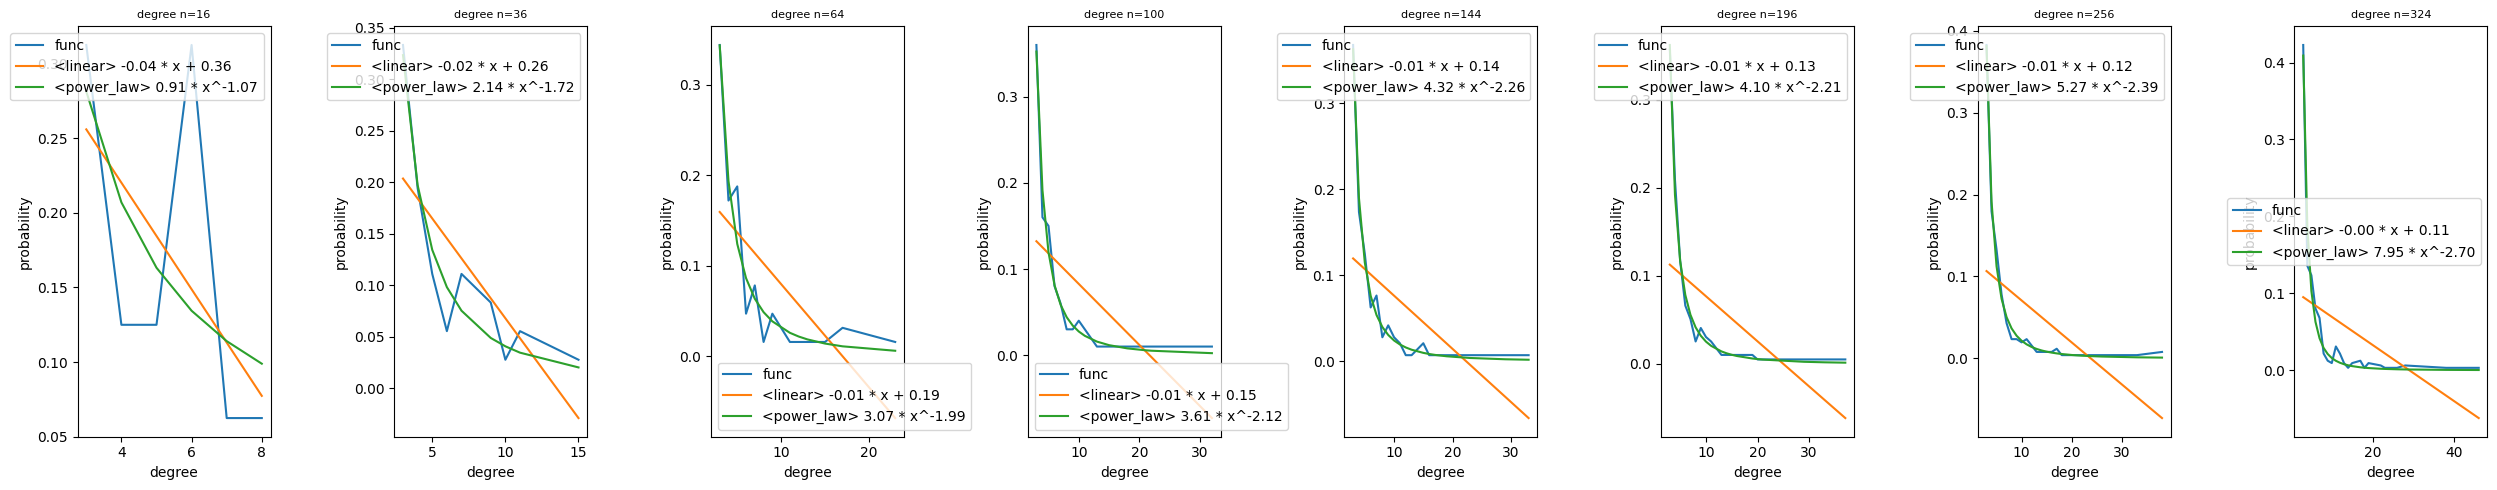

In [ ]:
approxim_by = {
    'diameter': [fit_linear, fit_log],
    'density': [fit_linear, fit_power_law],
    'average_local_clustering_cf': [fit_linear, fit_power_law],
    'global_clustering_cf': [fit_linear, fit_power_law],
    'average_length': [fit_linear, fit_log],
    'degree': [fit_linear, fit_power_law],
}

plot_metrics(n_range, n_metrics, 'n', approxim_by)

Анализ:

1. diameter и средняя пути растут логарифмически при росте n
2. density уменьшается по степенному закону при росте n
3. коэффициенты кластеризации уменьшаются по степенному закону при росте n

Нижние графики можно аппроксимировать степенным законом. Не зависит относительно n

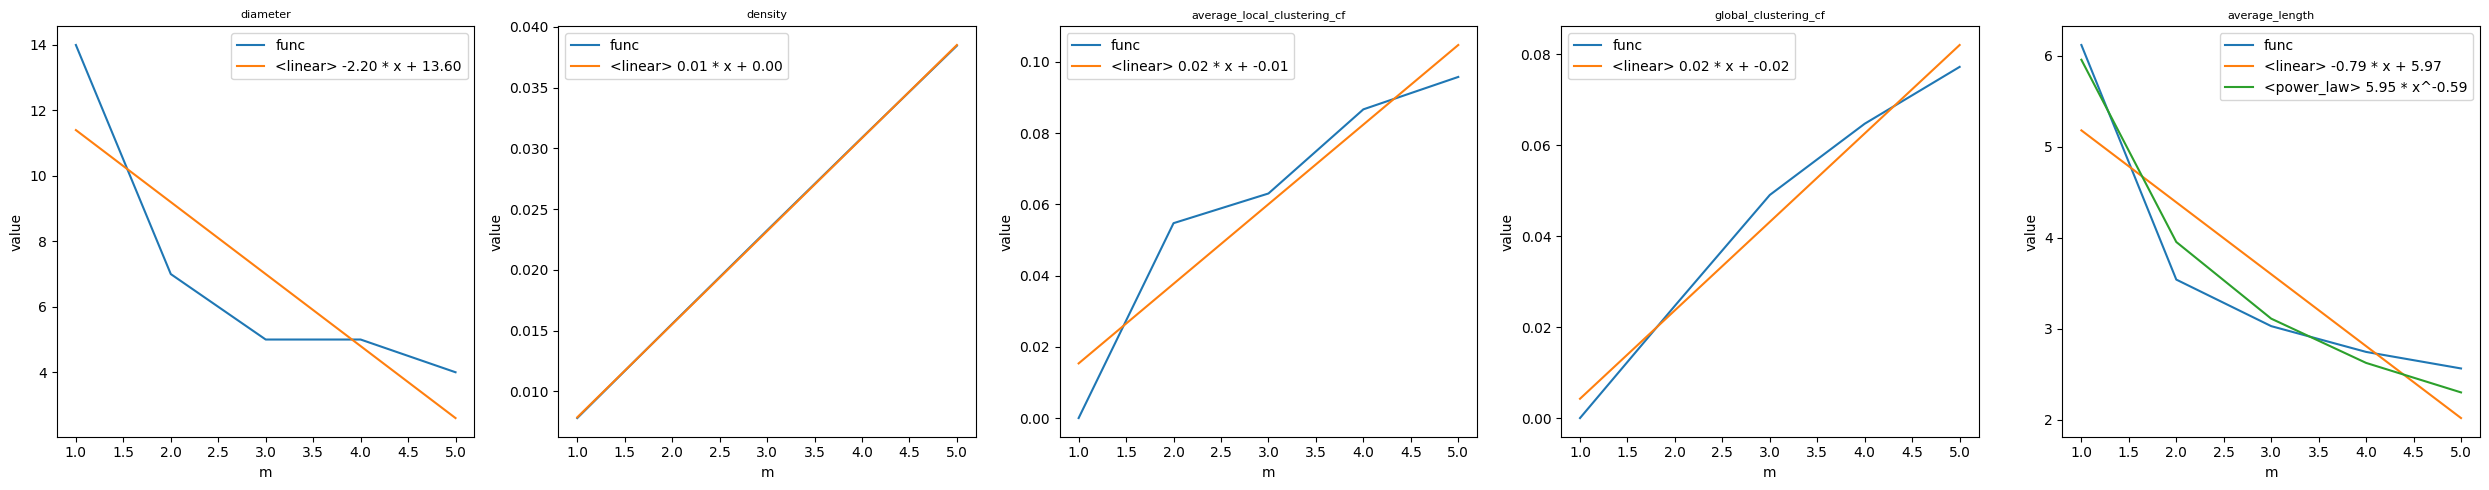

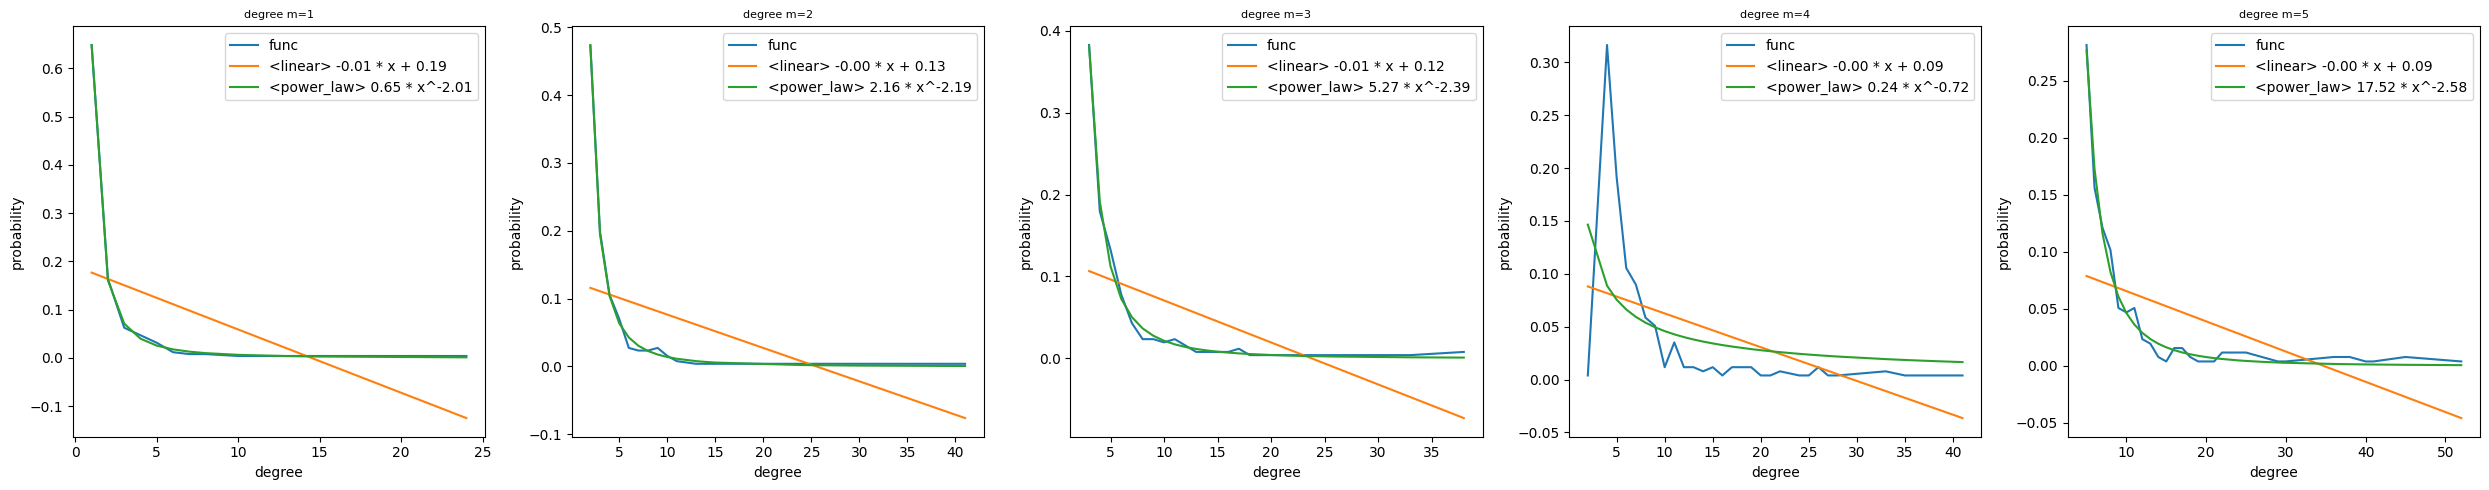

In [ ]:
approxim_by = {
    'diameter': [fit_linear],
    'density': [fit_linear],
    'average_local_clustering_cf': [fit_linear],
    'global_clustering_cf': [fit_linear],
    'average_length': [fit_linear, fit_power_law],
    'degree': [fit_linear, fit_power_law],
}

plot_metrics(m_range, m_metrics, 'm', approxim_by)

Анализ:

1. diameter и средняя пути окололинейно уменьшаются при увеличении m
2. density линейно увеличивается росте m
3. коэффициенты кластеризации увеличиваются при росте m

Нижние графики можно аппроксимировать степенным законом. При увеличении m график смещается вправо что очевидно т.к увеличивается m.

Выводы: Степени вершин распределены по степенному закону. Диаметр графа и средняя длина между двумя вершинами растут логарифмически. Однако коэфициент кластеризации достаточно низкий.

# Kleinberg

n - размер сетки (итоговое число вершин будет в квадрате), p - максимальная длина коротких соединений q - количество длинных соединений, r - степень, отвечающая за вероятность появления длинного соединения

Рассмотрим только n и q, так как остальные параметры являются оптимальными

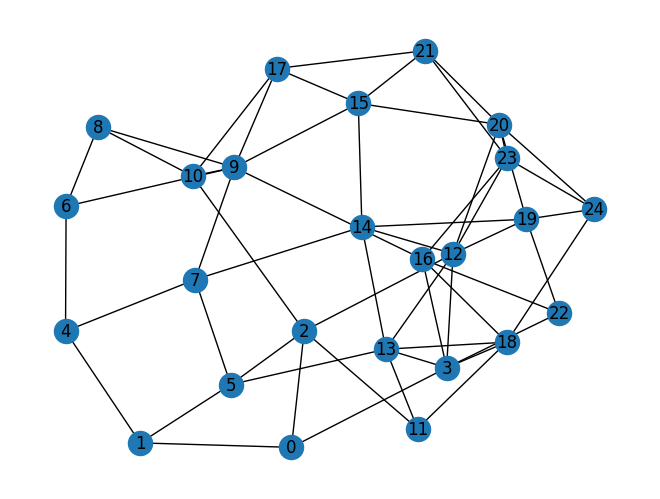

In [ ]:
g = nx.navigable_small_world_graph(5, p=1, q=1, r=2,  seed=228).to_undirected()
g.remove_edges_from(nx.selfloop_edges(g))
g = nx.convert_node_labels_to_integers(g)
g = make_graph_connected(g)

nx.draw(g, with_labels = True)

is_connected :  True
diameter :  5
density :  0.18666666666666668
average_local_clustering_cf :  0.2518095238095238
global_clustering_cf :  0.2523364485981308
average_length :  2.3366666666666664


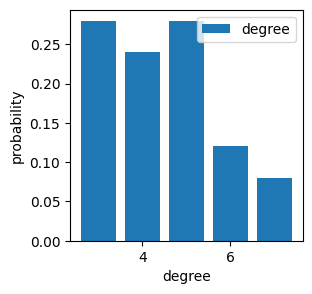

In [ ]:
is_connected, diameter, density, average_local_clustering_cf, global_clustering_cf, (degree_values, degree_hist), average_length = get_metrics(g)
%p is_connected
%p diameter
%p density
%p average_local_clustering_cf
%p global_clustering_cf
%p average_length

plt.figure(figsize=(3, 3))
plt.bar(degree_values, degree_hist)
plt.legend(['degree'])
plt.xlabel('degree')
plt.ylabel('probability')
plt.show()

In [ ]:
def handle_kleinberg_graph(g):
  g.remove_edges_from(nx.selfloop_edges(g))
  g = nx.convert_node_labels_to_integers(g)
  g = make_graph_connected(g)
  return g


q_range = [1, 2, 3, 4, 5, 6]
n_range = [x * x for x in range(4, 20, 2)]

n_metrics = defaultdict(list)
fixed_q = 1

q_metrics = defaultdict(list)
fixed_n = 3

# Метрики по n
for param in n_range:
    get_graph = lambda param: make_graph_connected(handle_kleinberg_graph(nx.navigable_small_world_graph(int(pow(param, 0.5)), q=fixed_q, seed=228).to_undirected()))
    calc_metrics(param, get_graph, n_metrics, avg_times=10)

# Метрики по q
for param in q_range:
    get_graph = lambda param: make_graph_connected(handle_kleinberg_graph(nx.navigable_small_world_graph(fixed_n, q=param, seed=228).to_undirected()))
    calc_metrics(param, get_graph, q_metrics, avg_times=10)

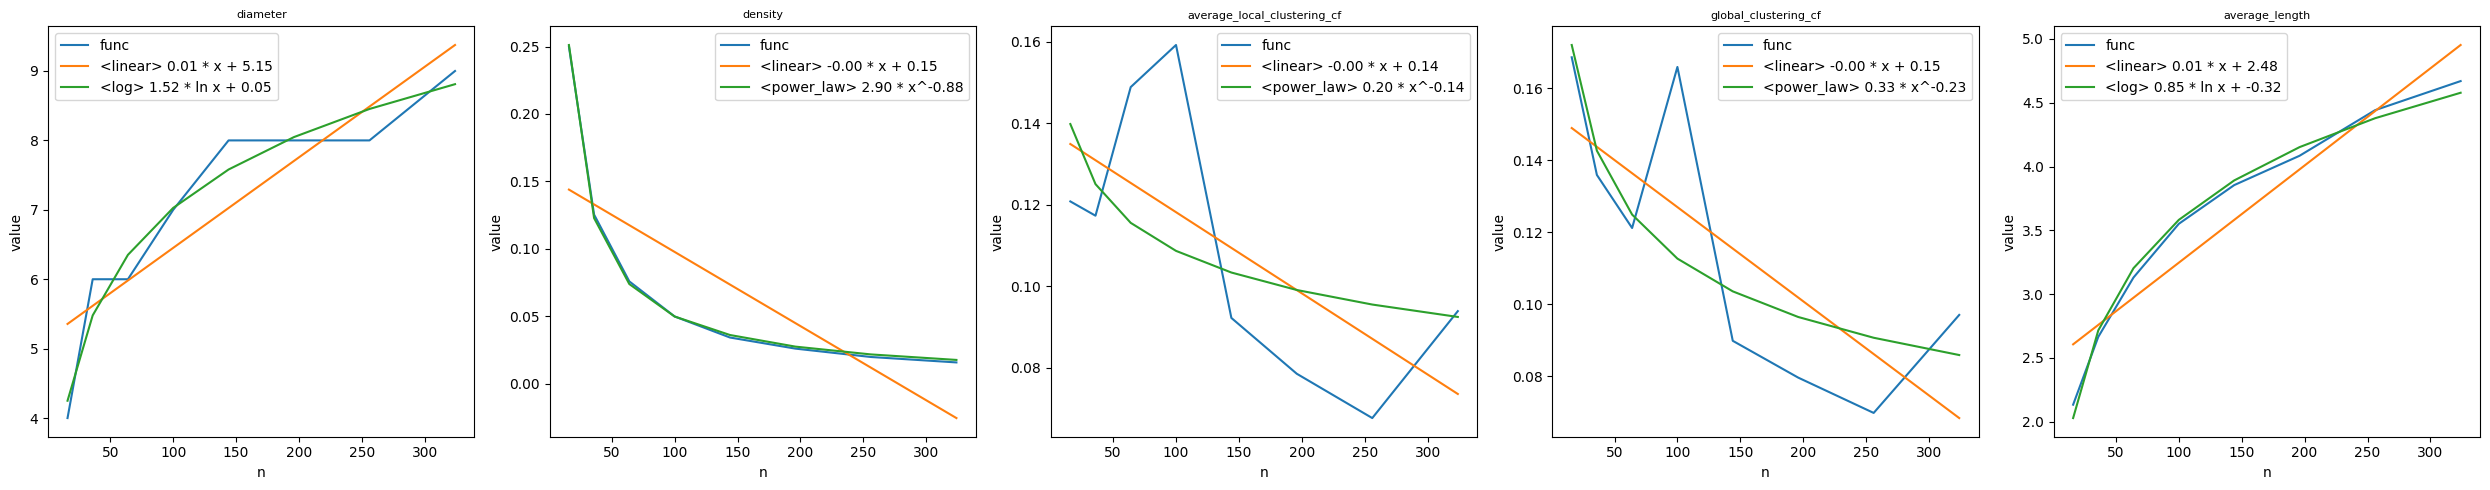

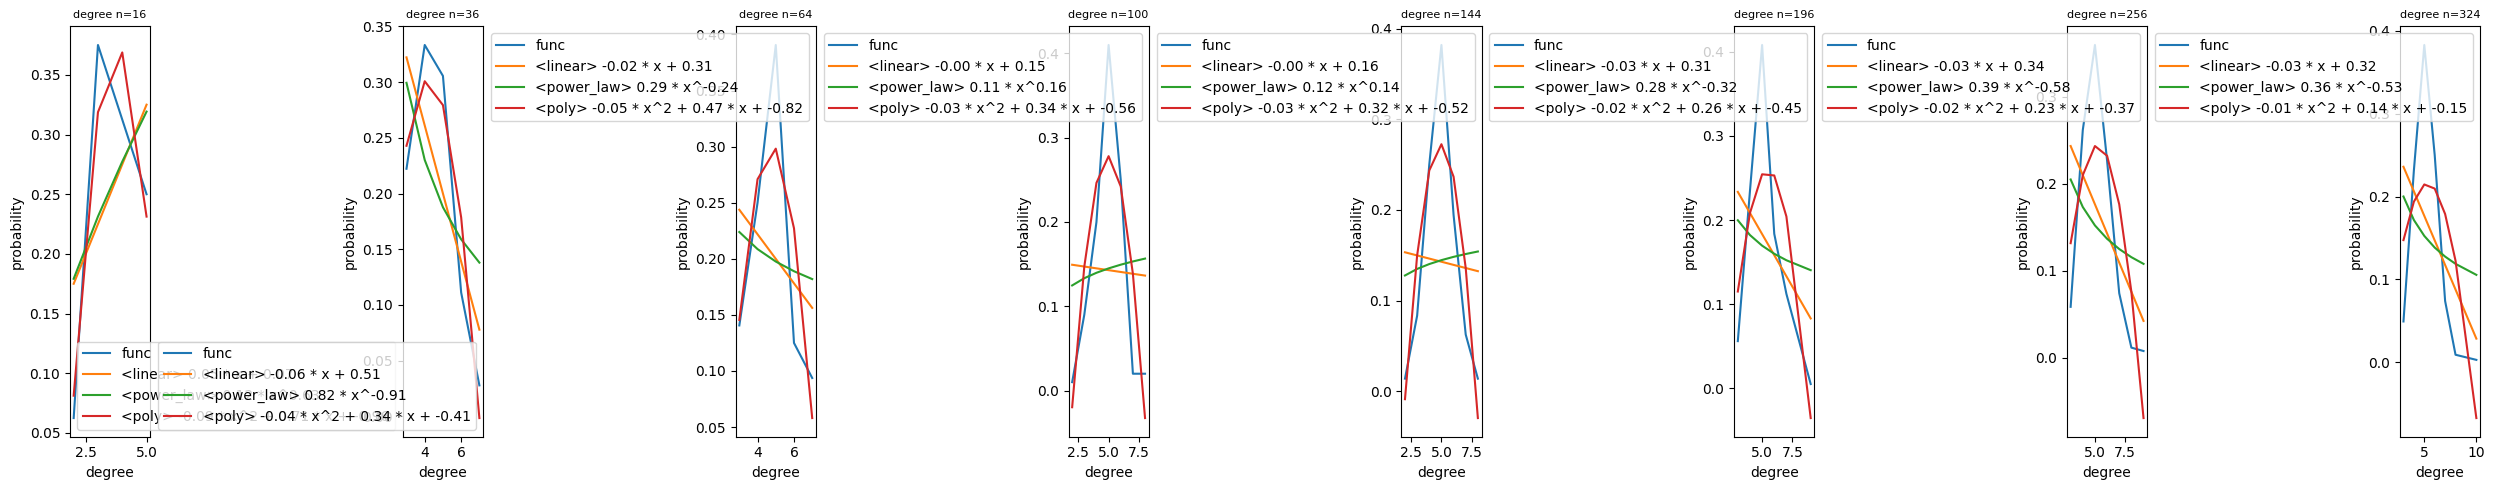

In [ ]:
approxim_by = {
    'diameter': [fit_linear, fit_log],
    'density': [fit_linear, fit_power_law],
    'average_local_clustering_cf': [fit_linear, fit_power_law],
    'global_clustering_cf': [fit_linear, fit_power_law],
    'average_length': [fit_linear, fit_log],
    'degree': [fit_linear, fit_power_law, fit_poly2d],
}

plot_metrics(n_range, n_metrics, 'n', approxim_by)

Анализ:

1. diameter и средняя пути логарифмически растут при увеличении n
2. density уменьшается по степенному закону при увеличении n
3. коэффициенты кластеризации имеют сложную структуру, лучше всего аппроксимируются по степенному закону

Нижние графики можно аппроксимировать полиномом второй степени.

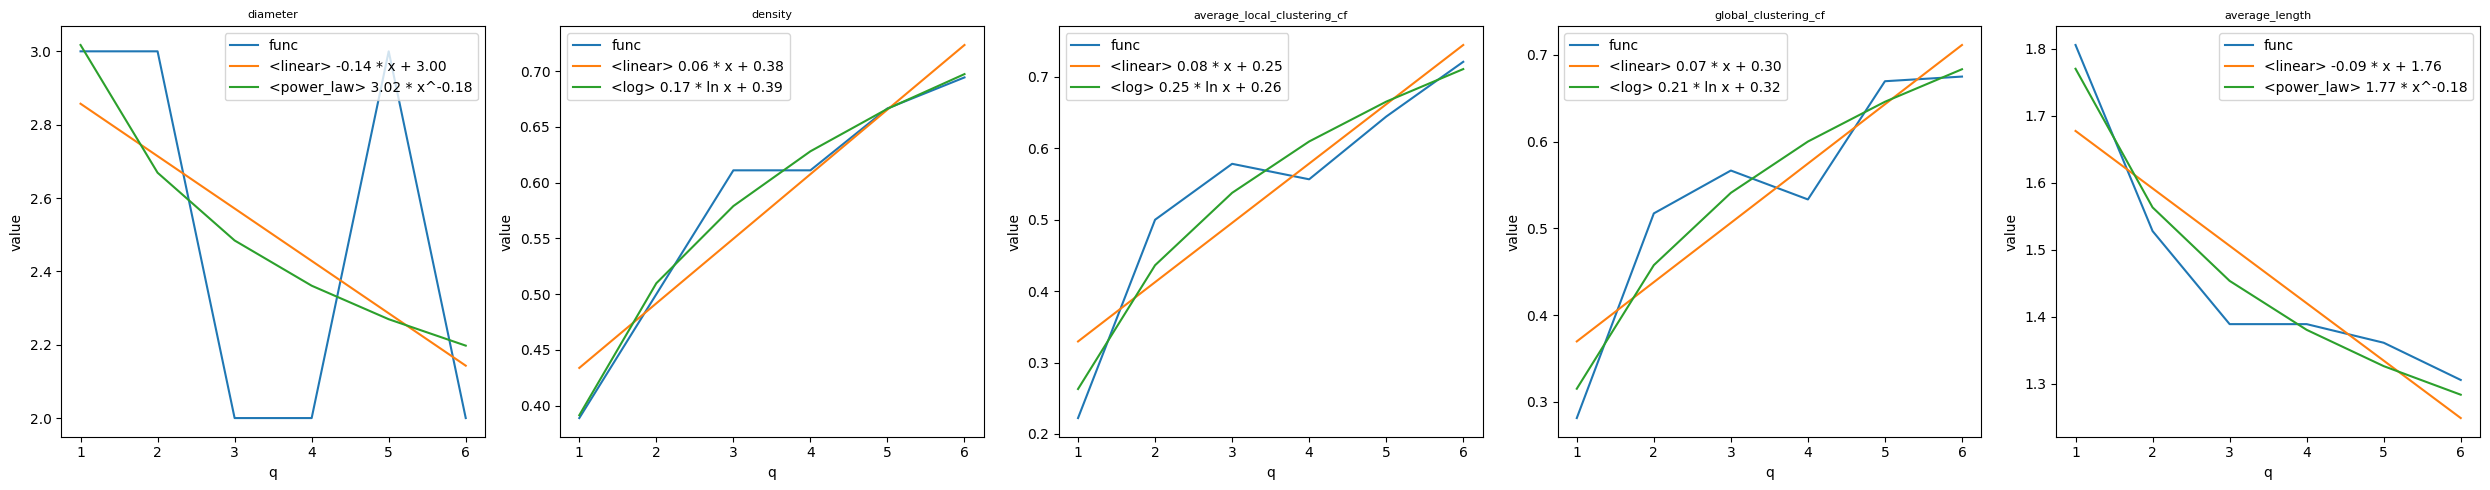

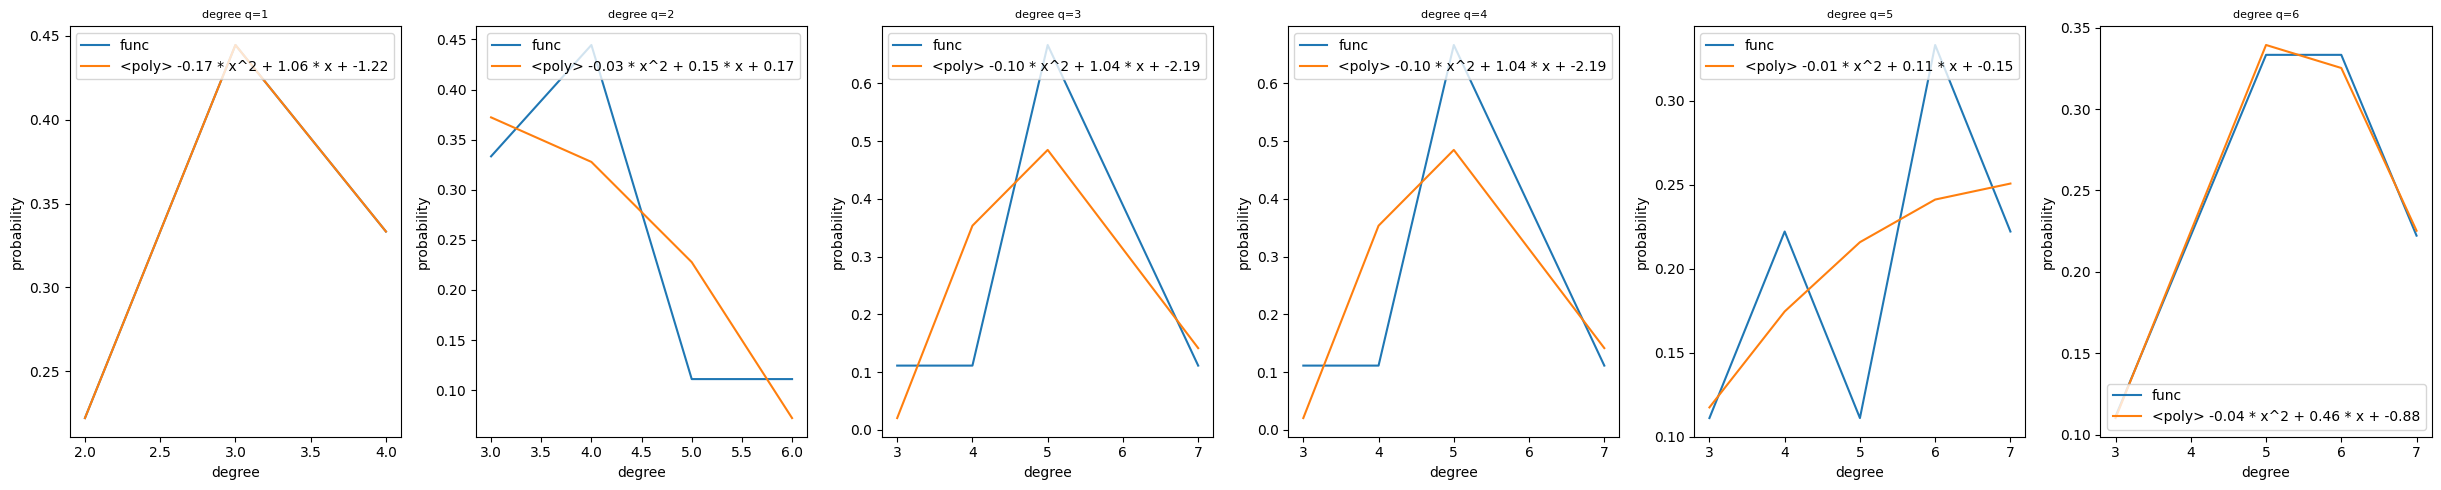

In [ ]:
approxim_by = {
    'diameter': [fit_linear, fit_power_law],
    'density': [fit_linear, fit_log],
    'average_local_clustering_cf': [fit_linear, fit_log],
    'global_clustering_cf': [fit_linear, fit_log],
    'average_length': [fit_linear, fit_power_law],
    'degree': [fit_poly2d],
}

plot_metrics(q_range, q_metrics, 'q', approxim_by)

Анализ:

Можно отметить явную прямопропорциональную зависимость между числом дальних связей, кф кластеризации и плотностью. Также видно что диаметр и среднее расстояние уменьшаются с ростом q. Однако сложно определить тип аппроксимирующей функции - она либо линейная, либо логарифмическая / степенная

Выводы: Видно, что графы обладают сравнительно небольшим диаметром, возможно диаметр растет логарифмически с увеличением n. Однако степени вершин явно распределены не по степенному закону.

# Navigable small world

n - число нод графа, k - со сколькими ближайшими соседями будет соединена новая вершина

In [ ]:
# Реализация Approximate nearest neighbor algorithm based on navigable small world graphs
# Метрика расстояния изменена c cosine на euclidean
# http://ethen8181.github.io/machine-learning/deep_learning/multi_label/nsw.html#Navigable-Small-World

class Node:
    """
    Node for a navigable small world graph.

    Parameters
    ----------
    idx : int
        For uniquely identifying a node.

    value : 1d np.ndarray
        To access the embedding associated with this node.

    neighborhood : set
        For storing adjacent nodes.

    References
    ----------
    https://book.pythontips.com/en/latest/__slots__magic.html
    https://hynek.me/articles/hashes-and-equality/
    """
    __slots__ = ['idx', 'value', 'neighborhood']

    def __init__(self, idx, value):
        self.idx = idx
        self.value = value
        self.neighborhood = set()

    def __hash__(self):
        return hash(self.idx)

    def __eq__(self, other):
        return (
            self.__class__ == other.__class__ and
            self.idx == other.idx
        )

def nsw_knn_search(
    graph: List[Node],
    query: np.ndarray,
    k: int=5,
    m: int=50) -> Tuple[List[Tuple[float, int]], float]:
    """
    Performs knn search using the navigable small world graph.

    Parameters
    ----------
    graph :
        Navigable small world graph from build_nsw_graph.

    query : 1d np.ndarray
        Query embedding that we wish to find the nearest neighbors.

    k : int
        Number of nearest neighbors returned.

    m : int
        The recall set will be chosen from m different entry points.

    Returns
    -------
    The list of nearest neighbors (distance, index) tuple.
    and the average number of hops that was made during the search.
    """
    result_queue = []
    visited_set = set()

    hops = 0
    for _ in range(m):
        # random entry point from all possible candidates
        entry_node = random.randint(0, len(graph) - 1)
        entry_dist = distance.cosine(query, graph[entry_node].value)
        candidate_queue = []
        heapq.heappush(candidate_queue, (entry_dist, entry_node))

        temp_result_queue = []
        while candidate_queue:
            candidate_dist, candidate_idx = heapq.heappop(candidate_queue)

            if len(result_queue) >= k:
                # if candidate is further than the k-th element from the result,
                # then we would break the repeat loop
                current_k_dist, current_k_idx = heapq.nsmallest(k, result_queue)[-1]
                if candidate_dist > current_k_dist:
                    break

            for friend_node in graph[candidate_idx].neighborhood:
                if friend_node not in visited_set:
                    visited_set.add(friend_node)

                    friend_dist = distance.euclidean(query, graph[friend_node].value)
                    heapq.heappush(candidate_queue, (friend_dist, friend_node))
                    heapq.heappush(temp_result_queue, (friend_dist, friend_node))
                    hops += 1

        result_queue = list(heapq.merge(result_queue, temp_result_queue))

    return heapq.nsmallest(k, result_queue), hops / m

def build_nsw_graph(index_factors: np.ndarray, k: int) -> List[Node]:
    n_nodes = index_factors.shape[0]

    graph = []
    for i, value in enumerate(index_factors):
        node = Node(i, value)
        if i > k:
            neighbors, hops = nsw_knn_search(graph, node.value, k)
            neighbors_indices = [node_idx for _, node_idx in neighbors]
        else:
            neighbors_indices = list(range(i))

        # insert bi-directional connection
        node.neighborhood.update(neighbors_indices)
        for i in neighbors_indices:
            graph[i].neighborhood.add(node.idx)

        graph.append(node)

    return graph


def to_networkx(nodes):
  graph = nx.Graph()
  for node in nodes:
    graph.add_node(node.idx)

  for node in nodes:
    for friend in node.neighborhood:
      graph.add_edge(node.idx, friend)

  return graph

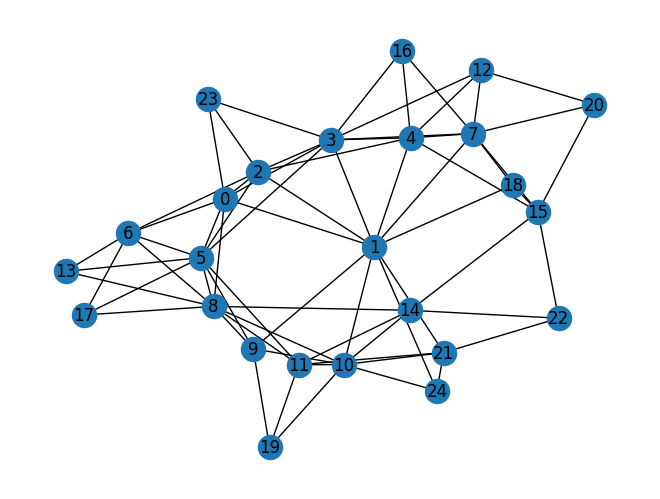

In [ ]:
vectors = np.random.rand(25, 2)
nodes = build_nsw_graph(vectors, 3)
g = to_networkx(nodes)
nx.draw(g, with_labels = True)

is_connected :  True
diameter :  4
density :  0.23
average_local_clustering_cf :  0.5686984126984127
global_clustering_cf :  0.4342105263157895
average_length :  2.1433333333333335


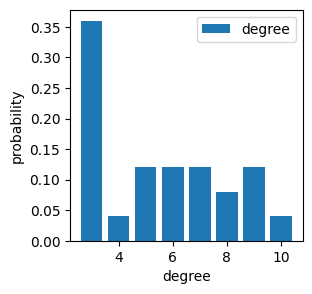

In [ ]:
is_connected, diameter, density, average_local_clustering_cf, global_clustering_cf, (degree_values, degree_hist), average_length = get_metrics(g)
%p is_connected
%p diameter
%p density
%p average_local_clustering_cf
%p global_clustering_cf
%p average_length

plt.figure(figsize=(3, 3))
plt.bar(degree_values, degree_hist)
plt.legend(['degree'])
plt.xlabel('degree')
plt.ylabel('probability')
plt.show()

In [ ]:
k_range = [1, 2, 3, 4, 5]
n_range = [x * x for x in range(4, 20, 2)]

n_metrics = defaultdict(list)
fixed_k = 3

k_metrics = defaultdict(list)
fixed_n = 100

# Метрики по n
for param in n_range:
    get_graph = lambda param: to_networkx(build_nsw_graph(np.random.rand(param, 2), fixed_k))
    calc_metrics(param, get_graph, n_metrics, avg_times=10)

# Метрики по k
for param in k_range:
    get_graph = lambda param: to_networkx(build_nsw_graph(np.random.rand(fixed_n, 2), param))
    calc_metrics(param, get_graph, k_metrics, avg_times=10)

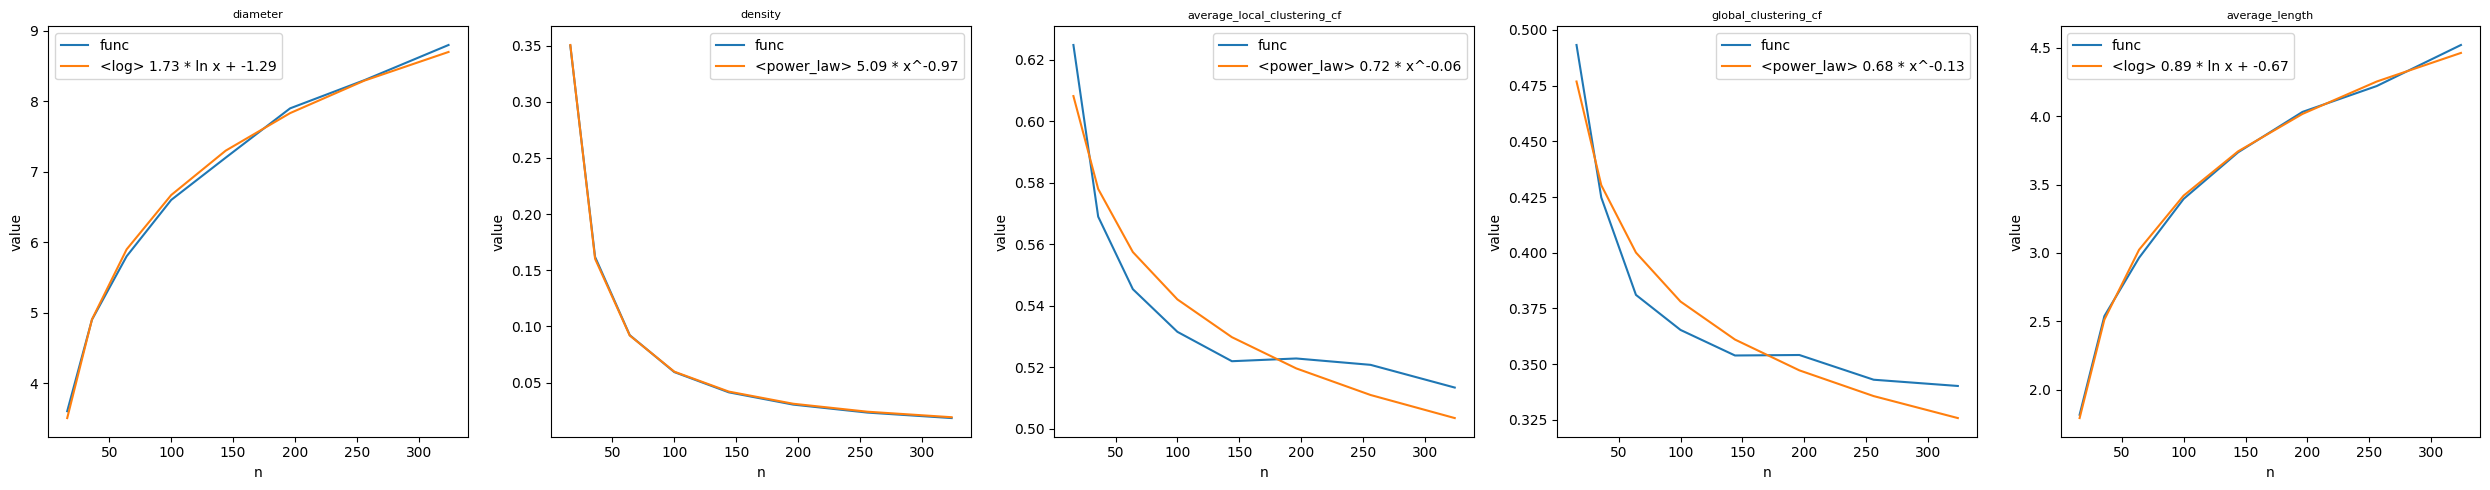

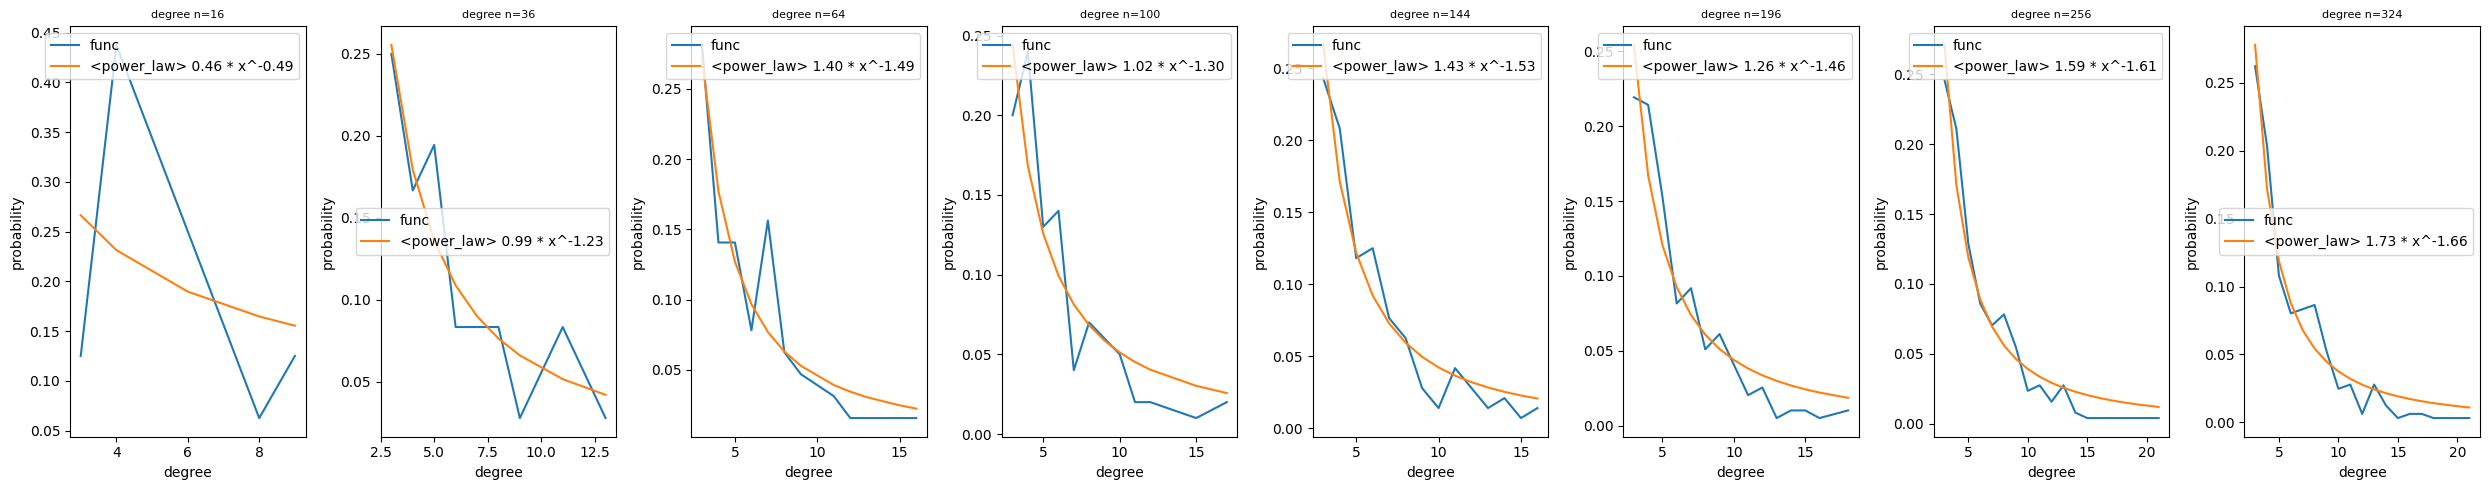

In [ ]:
approxim_by = {
    'diameter': [fit_log],
    'density': [fit_power_law],
    'average_local_clustering_cf': [fit_power_law],
    'global_clustering_cf': [fit_power_law],
    'average_length': [fit_log],
    'degree': [fit_power_law],
}

plot_metrics(n_range, n_metrics, 'n', approxim_by)

Анализ:

Видно, что диаметр растет логарифмически с увеличением n.

В то же время плотность и кф кластеризации также уменьшаются по степенному закону (возможно логарифмически)

Степени распределены по степенному закону - и это становится все более явно при увеличении n

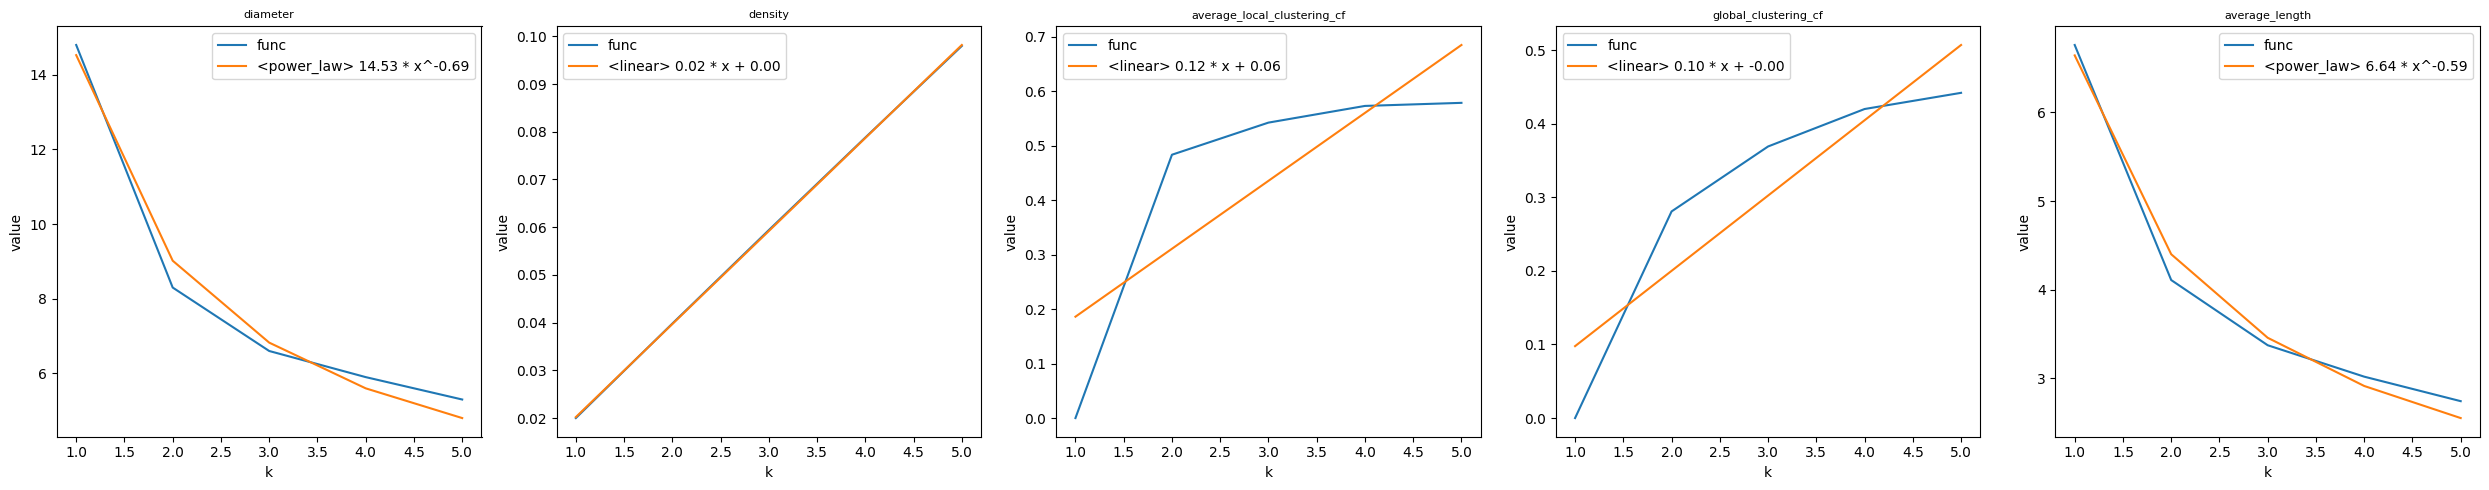

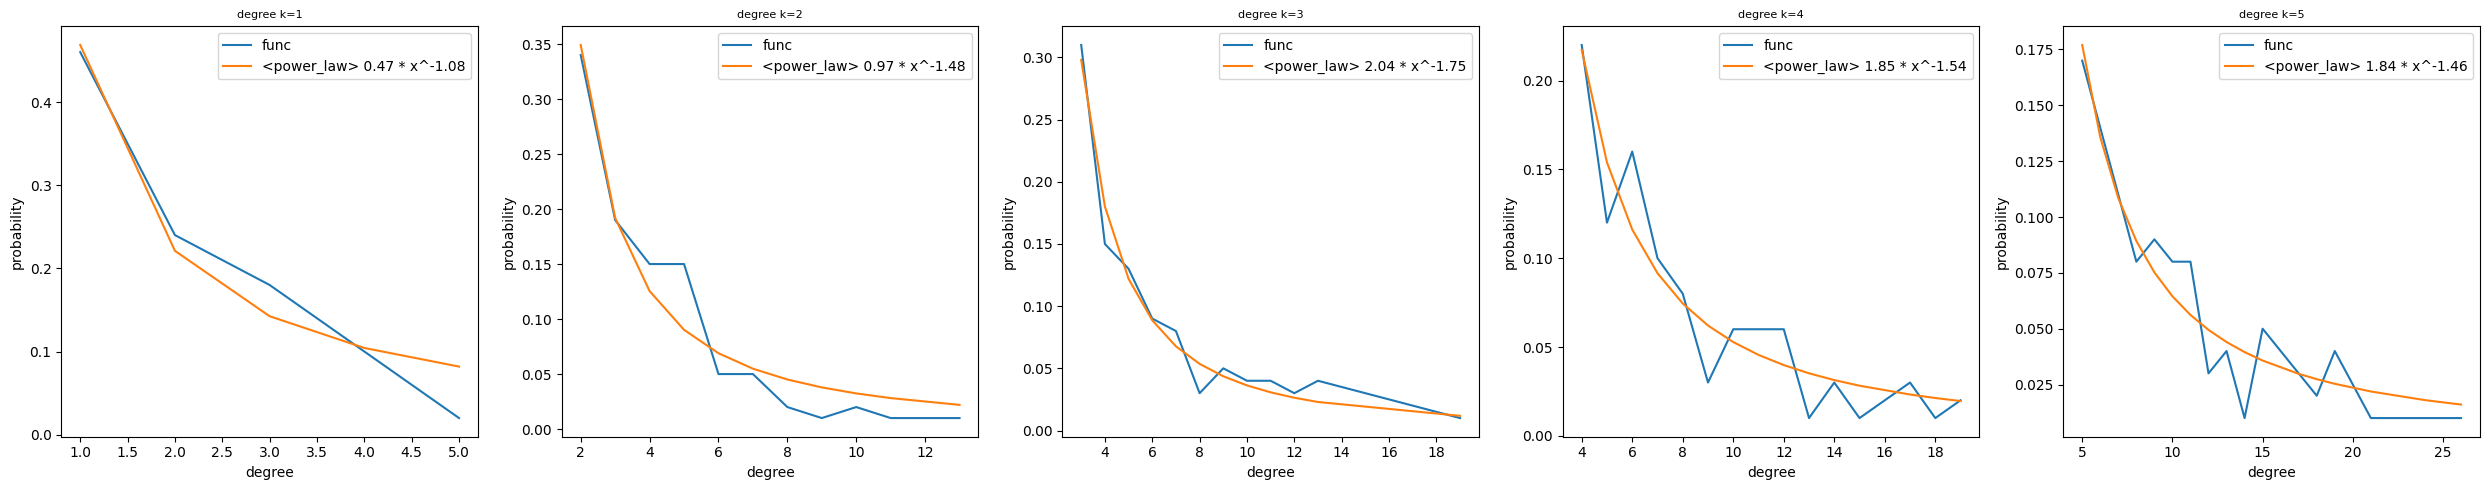

In [ ]:
approxim_by = {
    'diameter': [fit_power_law],
    'density': [fit_linear],
    'average_local_clustering_cf': [fit_linear],
    'global_clustering_cf': [fit_linear],
    'average_length': [fit_power_law],
    'degree': [fit_power_law],
}

plot_metrics(k_range, k_metrics, 'k', approxim_by)

Анализ:

Очевидно, что при увеличении k ближайших соседей уменьшается диаметр и среднее расстояние между вершинами и увеличиваются кф кластеризации с плотностью.

При увеличении k видно что степени вершин смещаются вправо, что тоже очевидно т.к увеличивается минимальная степень вершин.

Выводы: Модель наилучшим образом реализует модель тесного мира, т.к степени вершин распределены по степенному закону, диаметр относительно небольшой и растет логарифмически, а также кф кластеризации достаточно большие по сравнению с остальными графиками + можно его регулировать через k